In [6]:
from sys import path
if '..' not in path:
    path.insert(0, '..')

In [7]:
from matplotlib.ticker import MaxNLocator
from os import listdir, path
from datetime import date
from random import randrange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from _library.utils import SYSTEM_NAMES, SUBFOLDERS, load_datasets
import _library.fault_utils as fault_utils
from dateutil.parser import ParserError
from string import ascii_uppercase
from scipy.stats import stats

In [8]:
# Folder path
%cd /mnt/data/vieri/projects/SAMPLE/

# Visualize names of PV systems
print(SYSTEM_NAMES, "\n")
print(SUBFOLDERS)
# --- 0 ---------- 1 --------- 2 ------ 3 ------ 4 --------- 5 --------- 6 -------- 7 ---

/mnt/data/vieri/projects/SAMPLE
['Binetto 1', 'Binetto 2', 'Soleto 1', 'Soleto 2', 'Galatina'] 

['Cleaned', '1-hour sampling', '1-hour averaged sampling', 'Residuals', 'Residuals_analytical', None]


In [9]:
system_name = SYSTEM_NAMES[4]

In [10]:
subfolder = "Cleaned"
folder_path, inv_data, inv_names, raw_irr_data, string_inv_data, string_inv_names = load_datasets(system_name, 
                                                                                                  verbose=True,
                                                                                                  subfolder = subfolder)

-------------------------------------------------------------------------------- 
				PV SYSTEM --> GALATINA 
--------------------------------------------------------------------------------

Loading inverter data...
GALATINA: OK, component data loaded (4) --> INV1, INV2, INV3, INV4

Loading irradiance values...
GALATINA: OK, raw irradiance data (234226 observations) have been loaded

-------------------------------------------------------------------------------- 
FINISHED!: All datasets have been loaded. (SYS: 4 - IRR FILE: 1)
--------------------------------------------------------------------------------
-------------------------------------------------------------------------------- 
EXAMPLE --> Galatina: INV1 (FROM '2016-05-02' TO '2021-06-30': 1885 days).
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99396 entries, 0 to 99395
Data columns (total 13 columns):
 #   Column               Non-Null Co

In [ ]:
df_main = inv_data[inv_names[0]]
df = string_inv_data[string_inv_names[52]]
df.info()
display(df)
cond_kwh = df["Generated Energy (kilowatt-hours)"] > 1000 #50000
cond = df["Voltage BN (volts)"] == 0
beyond = df[cond]

for idk in beyond.index.tolist():
    time_window = 3
    neighbourhood = df.iloc[idk - time_window: idk + time_window +1, :]
    print("IDK: ", idk)
    display(neighbourhood)
#  2020-07-25 09:05:00
#display(df.iloc[114010, :])

In [ ]:
# TASK: Numerical comparison between the 'SYSTEM' sheet and the 'SPECIAL STRING INVERTER'

# Select the inverters
special_stringInv_idk = 52 if system_name == SYSTEM_NAMES[0] else 0
system = inv_data[inv_names[0]].copy()
string_inverter = string_inv_data[string_inv_names[special_stringInv_idk]].copy()

print(system['Generated Power [Average(watts)]'].describe().apply(lambda x: x/1000))

# Set the timestamps as index to compare them 
system.index = system["Date/Time [Europe/Rome]"]
system.drop(columns = "Date/Time [Europe/Rome]", inplace=True)
string_inverter.index = string_inverter["Date/Time [Europe/Rome]"]
string_inverter.drop(columns = "Date/Time [Europe/Rome]", inplace=True)

# Find common columns
common_columns = sorted(list(set(system.columns).intersection(string_inverter.columns)), reverse=True)
print(f"\nCOMMON COLUMNS ({len(common_columns)}/{len(system.columns)}):\n", 60*"-")
print(('\n').join(common_columns), "\n")

period_system = (system.dropna(how="all").index[0].strftime('%Y/%m/%d'), 
                 system.dropna(how="all").index[-1].strftime('%Y/%m/%d'))
period_stringInv = (string_inverter.dropna(how="all").index[0].strftime('%Y/%m/%d'), 
                    string_inverter.dropna(how="all").index[-1].strftime('%Y/%m/%d'))
print("PERIODS\n", 60*"-")
print("PERIOD (SYSTEM): \t     ", (" - ").join(period_system))
print(f"PERIOD (STRING INVERTER {special_stringInv_idk +1}): ", (" - ").join(period_stringInv))
print("PERIOD MISSED:  ", pd.to_datetime(period_system[0]) - pd.to_datetime(period_stringInv[0]))
print("PERIOD AVAILABLE:", pd.to_datetime(period_stringInv[-1]) - pd.to_datetime(period_stringInv[0]), "\n")

similar_columns = []
for col in common_columns: 
    print("-"*10, f"COLUMN: {col}", 10*"-")
    
    # Compute the difference 
    diff = np.abs(system[col] - string_inverter[col])
    valid_diff = diff[~diff.isna()]
    non_equal = valid_diff[valid_diff > 0]
    
    # Compute some metrics
    mean= np.round(np.mean(valid_diff), 2)
    std = np.round(np.std(valid_diff), 2)
    
    #  Detect whether it could be classified as similar 
    threshold = 1
    are_similar = True if (mean <= threshold and std <= threshold) else False
    if are_similar == True:
        similar_columns.append(col) 
    
    # Visual output
    print(f"Different observations {len(non_equal)}/{len(valid_diff)} "\
          f"({round((len(non_equal)/len(valid_diff))*100, 2) }%) "\
          f"with {len(valid_diff) - len(non_equal)} equal obserbations ({round((1 - (len(non_equal)/len(valid_diff)))*100, 2) }%).")
    print(f"MEAN (abs diff): {mean}\nSTD (abs diff): {std}\n")
    
    # Example of an observation
    random_timestamp = valid_diff.index[randrange(len(valid_diff.index))] 
    comparison_df = pd.DataFrame(
        index = ["System", "String Inverter", "Diff"],
        columns = [col.replace("[Average", "").rstrip("]")], #.split("[")[0]
        data = [
            system[col].loc[random_timestamp],
            string_inverter[col].loc[random_timestamp],
            valid_diff.loc[random_timestamp]
        ])
    print("RANDOM TIMESTAMP:", random_timestamp)
    display(comparison_df.round(decimals=2))
    
# Visualize the similar columns
print(100*"-")
print(f"FINDINGS: {len(similar_columns)} COLUMNS THAT SEEM SIMILAR (absolute diff. <= 1 & std. <= 1):")
print(("\n").join(similar_columns))

# watt --> kwatt

In [ ]:
# TASK: Calcola valore teorico della potenza AC
dc_power_col= "DC Gen. Power [Average(watts)]"
ac_power_col = "Generated Power [Average(watts)]"

pd.set_option('display.max_rows', 500)

# FORMULA: Watt (W) = Voltage (V) * Ampere (A)

# Compute DC current
# FORMULA: Ampere (A) = Watt (W) / Voltage (A)
cols = [dc_power_col] + ['DC Voltage [Average(volts)]'] 
computed_dc_current = inv_data[inv_names[0]][ac_cols[0]] / inv_data[inv_names[0]][ac_cols[1]]
inv_data[inv_names[0]]["computed_dc_current [A = W/V]"] = computed_dc_current

# Compute avg e std
tmp = computed_dc_current
inf_values = len(tmp[tmp == np.inf])
tmp[tmp == np.inf] = np.nan
tmp = tmp.dropna()
print("MEAN:", np.round(np.mean(tmp), 2), "STD: ", np.round(np.std(tmp), 2))
print(f"INF value discarted: {inf_values} ({round((inf_values / len(computed_dc_current))*100, 2)} %)")

# AC POWER
ac_cols = ["Voltage [Average(volts)]", "Current [Average(amps)]"]
computed_ac_power = np.round(inv_data[inv_names[0]][ac_cols[0]] * (inv_data[inv_names[0]][ac_cols[1]] * 77), 1)
inv_data[inv_names[0]]["computed_ac_power [Watts: V*A]"] = computed_ac_power

# VISUALIZE
cols = ['Date/Time [Europe/Rome]'] + ac_cols + [ac_power_col] + ["computed_ac_power [Watts: V*A]"] + [dc_power_col] 
new_df = inv_data[inv_names[0]][cols].dropna()
print(20 * "-", "AC POWER (data vs computed values)", 20 * "-")
display(new_df.iloc[300:400, :])

cols = ['Date/Time [Europe/Rome]'] + ['DC Voltage [Average(volts)]'] + ["computed_dc_current [A = W/V]"] +[dc_power_col]
new_df = inv_data[inv_names[0]][cols].dropna()
print(20 * "-", "DC CURRENT (computed values)", 20 * "-")
display(new_df.iloc[100:200, :])

# Test formula 
cols = ["DC Voltage [Average(volts)]", "DC Current [Average(amps)]","DC Current [Average(amps).1]", "Generated Power [Average(watts)]", ] #
wape_list = []
str_inv = string_inv_names[5]
x = string_inv_data[str_inv].dropna()

#(W = V * A)
voltage = x[cols[0]]
current = x[cols[1]] + x[cols[2]] # i due gruppi di coppie di stringhe --> le correnti si sommano
power = voltage * current 
x["computed_power (W = V*A)"] = np.round(formula, 1)
x["delta"] = np.abs(x[cols[3]] - x["computed_power (W = V*A)"])
wape = (np.sum(x["delta"]) / np.sum(x[cols[3]])) * 100
wape_list.append(wape)

# Visualize
cols = ['Date/Time [Europe/Rome]'] + cols + ["computed_power (W = V*A)"] + ["delta"]
display(x[cols].iloc[:500, :])
print(f"WAPE: {np.round(wape)} %") 
print("WAPE (AVG)", np.mean(wape_list))


In [ ]:
df = inv_data[inv_names[0]]
display(df.describe()["Vcc 1 (V)"])

pd.set_option('display.max_rows', 500)

# FILTER
cond = df["Vcc 1 (V)"] < 300
filtered = df[cond][["Date/Time", "Vcc 1 (V)"]]
display(filtered.iloc[:500, :])

In [ ]:
pd.set_option('display.max_rows', 500)

df = inv_data[inv_names[0]]

# Problematic obs
df["delta"] = [delta.components[1] if not pd.isnull(delta) else 0 for delta in df["Date/Time"].diff()]
cond1 = df["delta"] > 1
cond2 = df["Date/Time"].dt.time > pd.to_datetime("07:00").time()
problematic_obs = df[cond1 & cond2]
#df.drop(columns="delta", inplace=True)
print("Problematic observations:", len(problematic_obs), f"({round((len(problematic_obs)/len(df))*100, 2)}%)\n")
display(problematic_obs.iloc[:500, [0, -1]])

# Filtered df
cond3 = df["Irradiance (W/mq)"] > 1400
filtered_df = df[cond1].iloc[:500, :]
#display(df[df["Date/Time"].dt.date == pd.to_datetime("2019-06-20").date()])

#View all
#display(df.iloc[:500, :])
df.info()
display(df.describe())

In [ ]:
df = inv_data[inv_names[4]]
cond = df["Vac R (V)"] == 0
display(df[cond])

In [ ]:
# Compute difference between temperatures
to_load = inv_names[0]
x = pd.DataFrame(np.abs(inv_data[to_load]["Ambient Temp. [Average(celsius)]_SYS"] - inv_data[to_load]["Ambient Temp. [Average(celsius)]_AMB"]))
len_pre_x = len(x)
x = x.dropna()
print("NaN values dropped: ", len_pre_x - len(x))

# Highlight values with difference
diff = x[x.iloc[:, 0] > 0]
print("Observations with a DIFF:",len(diff))
display(diff)

print("MEAN: ", np.mean(x)[0])
print("STD: ", np.std(x)[0])

# STATEGY: Keep the one with the most value + join if missing values

In [ ]:
# ------------------------------------------------------------------------------------
# -------- TASK: Analiza comportamento trifase in un dato giorno ---------------------
# ------------------------------------------------------------------------------------
if (system_name != SYSTEM_NAMES[0]) and (system_name != SYSTEM_NAMES[1]):
    df = inv_data[to_load].copy()
    pd.set_option('display.max_rows', 1000)

    # To filter
    column_to_filter = datetime_column_name
    day_to_display = date(2020, 9, 1)
    cond = df[column_to_filter].dt.date == day_to_display  #.between("2020-01-13", "2020-01-13")

    # To visualize
    column_to_visualize = "Irradiance [Average(watts-per-meter-sq)]"
    filtered_df = df[cond].iloc[:, :8]
    filtered_df[datetime_column_name] = filtered_df[datetime_column_name].dt.strftime("%H:%M")
    filtered_df.rename(columns = {datetime_column_name: "Time"}, inplace=True)

    # Visual representation
    fig, axes = plt.subplots(nrows = 3, figsize=(15, 15))
    sns.set_theme(style="whitegrid")

    fig.suptitle(r"$\bf{" + system_name.upper().replace(' ','\\ ') + "}$: Trifase ["+ str(day_to_display) +"]",
                     fontsize=30, color='dimgray', y=0.99) #

    sns.scatterplot(data=filtered_df, x="Time", y="Iac R (A)", ax = axes[0], label ="Iac R", 
                    color= "red", s = 10, alpha=0.8)
    sns.scatterplot(data=filtered_df, x="Time", y="Iac S (A)", ax = axes[0], label ="Iac S", 
                    color= "orange",s = 10, alpha=0.8)
    sns.scatterplot(data=filtered_df, x="Time", y="Iac T (A)", ax = axes[0], label ="Iac T", 
                    color= "dodgerblue", s = 10, alpha=0.8)
    axes[0].xaxis.set_major_locator(MaxNLocator(18))
    axes[0].set_ylabel("Ampere [A]", fontsize="large", fontweight='bold', labelpad = 10)
    axes[0].set_xlabel("Time", fontsize="large", fontweight='bold', labelpad = 5)
    axes[0].set_title("Correnti", fontsize="xx-large")
    axes[0].tick_params(axis='y', which='major', grid_linestyle = "-.", grid_alpha=0.8)

    sns.scatterplot(data=filtered_df, x="Time", y="Vac R (V)", ax = axes[1], label ="Vac R", 
                    color= "red", s = 10, alpha=0.8)
    sns.scatterplot(data=filtered_df, x="Time", y="Vac S (V)", ax = axes[1], label ="Vac S", 
                    color= "orange", s = 10, alpha=0.8)
    sns.scatterplot(data=filtered_df, x="Time", y="Vac T (V)", ax = axes[1], label ="Vac T", 
                    color= "dodgerblue", s = 10,alpha=0.8)
    axes[1].xaxis.set_major_locator(MaxNLocator(18))
    axes[1].set_ylabel("Voltage [V]", fontsize="large", fontweight='bold', labelpad = 10)
    axes[1].set_xlabel("Time", fontsize="large", fontweight='bold', labelpad = 5)
    axes[1].set_title("Voltaggi", fontsize="xx-large")
    axes[1].tick_params(axis='y', which='major', grid_linestyle = "-.", grid_alpha=0.8)

    sns.scatterplot(x=filtered_df["Time"], y=filtered_df["Pac R (kW)"] , 
                    ax = axes[2], label ="Pac R", color= "dodgerblue")

    axes[2].xaxis.set_major_locator(MaxNLocator(18))
    axes[2].set_ylabel("Power [kW]", fontsize="large", fontweight='bold', labelpad = 10)
    axes[2].set_xlabel("Time", fontsize="large", fontweight='bold', labelpad = 5)
    axes[2].set_title("AC Power generated", fontsize="xx-large")
    axes[2].tick_params(axis='y', which='major', grid_linestyle = "-.", grid_alpha=0.8)

    fig.tight_layout(pad = 2)
    fig.savefig(folder_path, bbox_inches='tight', pad_inches=1)
    plt.show()
else:
    print("This analysis isn't necessary for this PV system!")

In [ ]:
to_load = inv_names[3]

In [ ]:
# ------------------------------------------------------------------------------------
# ----------------- TASK: Analizza il comportamento del sampling ---------------------
# ------------------------------------------------------------------------------------
pd.options.display.max_rows = 1000
print(50*"-"+ "SYSTEM: ", system_name.upper() + 50*"-")

# Set the dataset that should be analysed 
df = inv_data[to_load] 
#df = raw_irr_data

datetime_df = pd.DataFrame()
datetime_column_name = df.columns[0]

# Extract date and time
datetime_df["Date"] = df[datetime_column_name].dt.date
datetime_df["Time"] = df[datetime_column_name].dt.time 
datetime_df["SAMPLING TIME"] = datetime_df["Time"].apply(lambda time: "Even (XX:X0)" if time.minute % 2 == 0 else "Odd XX:X5")
datetime_df["SAMPLING [Min]"] = [delta.seconds//60 if not pd.isnull(delta) else 0 for delta in df[datetime_column_name].diff()]

# Compute the changes(i.e., deltas) of irradiance values
if df.columns[1] == "irr. medio 1 W/mq":
    datetime_df["Irradiance"] = df[df.columns[1]]
    datetime_df["Delta irr"] = np.absolute(df[df.columns[1]].diff())

# Exclude particular types of occurrences
# A) Midnight occurrences (00:00)
datetime_df = datetime_df[datetime_df["Time"] != pd.to_datetime("00:00:00").time()]

# B) First occurence of the day (e.g., 5:00 AM)
datetime_df["Same day"] = datetime_df["Date"].diff().apply(lambda diff: True if diff.days == 0 else False)
datetime_df = datetime_df[datetime_df["Same day"] == True]
datetime_df.drop(columns=["Same day"], inplace=True)

# Quick visualization of the unique sampling hours and deltas
print("UNIQUE SAMPLING HOURS:", sorted(set(time.hour for time in datetime_df["Time"].tolist())))
print("UNIQUE DELTA SAMPLING [min]:\n", sorted(datetime_df["SAMPLING [Min]"].unique()))

# VIEW 1: occurences for each type of the time (XX:X0: even, XX:X5: odd)
time_type_counter = datetime_df[["Time",  "SAMPLING TIME"]].groupby(["SAMPLING TIME"]).count()
time_type_counter.rename(columns = {"Time": "Occurrences"}, inplace=True)
print("\nTYPE OF SAMPLING TIMES")
display(time_type_counter)

# VIEW 2: Occurences for each type of sampling (e.g. 5, 10, 15 minutes)
type_counter = datetime_df[["Time",  "SAMPLING [Min]"]].groupby(["SAMPLING [Min]"]).count()
type_counter.rename(columns = {"Time": "Occurrences"}, inplace=True)
type_counter.sort_values(by=["Occurrences"], ascending=False, inplace=True)
print("\nOCCURENCES FOR EACH TYPE")
display(type_counter)
print(f"TOTAL: {len(datetime_df)} (first daily occurrences as well as the occurrence at midnight have been removed)")

# VIEW 3: Daily occurences for each type of sampling (count + mean/std for irradiance values )
if "Irradiance" in datetime_df.columns: 
    daily_type_counter = datetime_df[["Date",  "SAMPLING [Min]", "Time", "Delta irr"]]\
    .groupby(["Date", "SAMPLING [Min]"])\
    .agg(Occurrences = ("Time", "count"),
         Mean_deltaIrr = ("Delta irr", np.mean),
         Std_deltaIrr= ("Delta irr", np.std)
        )
else:
    daily_type_counter = datetime_df[["Date",  "SAMPLING [Min]", "Time"]]\
    .groupby(["Date", "SAMPLING [Min]"])\
    .agg(Occurrences = ("Time", "count"))
daily_type_counter = daily_type_counter.round(2)

# Extra column 3.1: Compute percentage of the grouped daily occurences
daily_occ = datetime_df[["Date", "Time"]].groupby(["Date"]).count()["Time"]
daily_percentages = round((daily_type_counter["Occurrences"] / daily_occ)*100, 1)
daily_type_counter.insert(1, "Percentage [%]", daily_percentages)
print("\nDAILY OCCURRENCES")
display(daily_type_counter.iloc[100:200,:])

# VIEW 4: Montly occurences for each type of sampling
montly_df = datetime_df[["Date", "Time", "SAMPLING [Min]"]]
montly_df["Month"] = pd.to_datetime(datetime_df["Date"]).dt.to_period('M')

month_type_counter = montly_df[["Month", "Time", "SAMPLING [Min]"]].groupby(["Month", "SAMPLING [Min]"]).count()
month_type_counter.rename(columns = {"Time": "Occurrences"}, inplace=True)

# Extra column 4.1: Compute percentage of the grouped montly occurences
montly_occ = montly_df[["Month", "Time",]].groupby(["Month"]).count()["Time"]
month_type_counter["Percentage [%]"] = round((month_type_counter["Occurrences"] / montly_occ)*100, 2)
print("\nDAILY OCCURRENCES")
display(month_type_counter.iloc[:100,:])

# VIEW 5: Compute the montly behaviour (Nominal VS wrong sampling) 
# 5.1) Define "Nominal" sampling as the most frequent one found out in the previous analysis (VIEW 2) 
default_sampling_time = type_counter.index.get_level_values('SAMPLING [Min]')[0]
is_nominal = lambda sampling_time: "Yes" if (sampling_time == default_sampling_time) else "No"
col_name = f"Default sampling time selected [{default_sampling_time} mins]"
montly_df[col_name] = montly_df["SAMPLING [Min]"].apply(is_nominal)

# 5.2) Group and visualize
default_sampling_counter = montly_df[["Month", "Time",col_name]].groupby(["Month", col_name]).count()
default_sampling_counter.rename(columns = {"Time": "Occurrences"}, inplace=True)
default_sampling_counter["Percentage [%]"] = round((default_sampling_counter["Occurrences"] / montly_occ)*100, 1)
default_sampling_counter.sort_values(by=["Month", "Occurrences"], ascending=[True, False], inplace=True)
display(default_sampling_counter)

# INSPECTION: Visualize problematic values/dates
val_cond = datetime_df["SAMPLING [Min]"] == 0
date_cond = datetime_df["Date"].between(date(2019, 5, 3), date(2019, 5, 5)) # == date(2020, 4, 27)
display(datetime_df.loc[date_cond,:])

# SAVE THE FINDINGS (as a multi-sheet excel file)
# Define file name and the saving folder
if "Irradiance" in datetime_df.columns:
    file_name = system_name + "_Irradiance sampling analysis.xlsx"
else:
    file_name = system_name + " - "+ to_load.capitalize() +" - Sampling analysis.xlsx"
saving_folder = path.join(folder_path, "..", "Distribution analyses")

# Excel writer
writer = pd.ExcelWriter(path.join(saving_folder, file_name))

# Create the different sheets
type_counter.to_excel(writer, sheet_name="Sampling")
default_sampling_counter.to_excel(writer, sheet_name="Monlty nominal behavioir")
daily_type_counter.to_excel(writer, sheet_name="Daily sampling")
month_type_counter.to_excel(writer, sheet_name="Montly sampling")
time_type_counter.to_excel(writer, sheet_name="Time types")
writer.save()

print("The findings have been saved in: ", saving_folder)

In [ ]:
# ------------------------------------------------------------------------------------
# --------------------- TASK: Analizza possibile colonne uguali  ---------------------
# ------------------------------------------------------------------------------------
df = inv_data[to_load].copy()

pairs_to_check = [
    ("Generated Energy [Interval Sum(kilowatt-hours)]", "PV Energy [Interval Sum(kilowatt-hours)]"),
    ("Generated Power [Average(watts)]", "PV Power [Average(watts)]")
]

for columns in pairs_to_check:    
    # Compute absolute difference
    df["diff"] = df[columns[0]] - df[columns[1]]
    diff = np.absolute(np.array(df["diff"]))
    
    # Compute mean and standard deviation
    mean = np.nanmean(diff)
    std = np.nanstd(diff)
    
    column_names = [col.split("[")[0].rstrip() for col in columns]
    print(f"DELTA: ({column_names[0]} VS {column_names[1]})")
    print(f"--> MEAN: {mean}")
    print(f"--> STD:  {std}\n")
    #display(df[[columns[0], columns[1], "diff"]].iloc[4100:4300])

In [ ]:
# ------------------------------------------------------------------------------------
# --------------------- TASK: Analizza buchi nei dati  ---------------------
# ------------------------------------------------------------------------------------
df = inv_data[to_load].copy()
empty_entries = df[df["Current [Average(amps)]"].isnull()]#["Date/Time [Europe/Rome]"]
empty_months = set(empty_entries.iloc[:, 0].dt.to_period('M').astype(str))

pd.options.display.max_rows = 10000
#print(empty_months)
display(empty_entries.iloc[80000:84210, 0])

# String Box alarms

## Load inverter data

In [24]:
system_name = SYSTEM_NAMES[2]
subfolder = "1-hour averaged sampling"

In [25]:
folder_path, inv_data, inv_names, *_, = load_datasets(system_name, verbose=True, subfolder = subfolder)

-------------------------------------------------------------------------------- 
				PV SYSTEM --> SOLETO 1 
--------------------------------------------------------------------------------

Loading inverter data...
SOLETO 1: OK, component data loaded (4) --> INV1, INV2, INV3, INV4
-------------------------------------------------------------------------------- 
FINISHED!: All datasets have been loaded. (SYS: 4 - IRR FILE: 0)
--------------------------------------------------------------------------------
-------------------------------------------------------------------------------- 
EXAMPLE --> Soleto 1: INV1 (FROM '2018-08-08' TO '2021-06-30': 1057 days).
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15586 entries, 0 to 15585
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date/Tim

## Retrieve *failure events* 

In [89]:
fault_priorities = ["High", "Medium"]

In [90]:
to_load = {
    'faults': True, 
    'inv_alarms': False, 
    'stringBox_alarms': True
}
include_faults_notRelatedToInverters = True

In [91]:
# Load the fault dataset: Storico guasti.xlsx (a.k.a., 'General faults') & PV SYSTEM - Storico Allarme.xlsx (a.k.a., Log - X)
fault_df = fault_utils.load_faults(system_name, include_faults_notRelatedToInverters, to_load['inv_alarms'], fault_priorities, 
                                   to_load['stringBox_alarms'], to_load['faults'], verbose = False)

# Isolate the fault in the period covered by the dataset
start_dates = [inv_data[inv_name].iloc[0, 0] for inv_name in inv_names]
first_start_date = sorted(start_dates)[0]
fault_df = fault_df[fault_df["Inizio"] >= first_start_date]

print("\n"+"-"* 120 + f"\n\t\t\t\t\t\tFAUL EVENTS (period >= {first_start_date.strftime('%Y-%m-%d')})")
print("\t\t\t\t\tPRIORITIES:", (', ').join([priority for priority in fault_df['Tipo'].unique()]) 
      + "\n" + "-"* 120)
display(fault_df)
print(f"TOTAL: {len(fault_df)} failure events")

# --------------- Isolate only the (general) faults observations ---------------------------------
fault_to_vis = "General Fault" 
fault_type_cond = fault_df["Tipo"] == fault_to_vis
print("\n"+"-"* 105 + f"\n\t\t\t\t\tFAULT EVENTS ('{fault_to_vis}')\n" + "-"* 105)
only_fault_df = fault_df[fault_type_cond]
if len(only_fault_df) > 0:
    display(only_fault_df)
else:
    print(f"\n[{system_name}] No faults available for this PV system.\n")

----------------------------------------------------------------------------------------------------
					FAULTS: Soleto 1
				PRIORITIES: High, Medium & faults
----------------------------------------------------------------------------------------------------
0) 1 fault(s) called 'scheda di comunicazione' have/has been discarted. As it's not related to inverter operation.

0) SELECTING only the string box-related faults

--> A) General faults loaded (1)
--> [B) Inverter logs have been skipped (0)]
--> C) String-box logs loaded (INV1: 31230, INV2: 3055, INV3: 5075, INV4: 1615)

Loading completed!

FAUL CAUSES (4):
--------------------
1) Allarme string-box
2) Ritardo comunicazione dispositivo
3) String-box con produzione anomala
4) Unknown

------------------------------------------------------------------------------------------------------------------------
						FAUL EVENTS (period >= 2018-08-08)
					PRIORITIES: Log_stringBox - Medium, Log_stringBox - High, General Fault
---------

,Inverter,Componente Guasto,Causa Guasto,Inizio,Fine,Tipo
3,3,CSP3.6 V130086: String-box con produzione anomala,String-box con produzione anomala,2018-08-08 11:51:00,2018-10-18 14:50:00,Log_stringBox - Medium
4,1,CSP1.6 V180544 s1: [3] Corrente di stringa fuo...,Allarme string-box,2018-08-08 13:26:00,2018-08-08 14:52:00,Log_stringBox - Medium
5,2,CSP2.6 V180556 s9: [3] Corrente di stringa fuo...,Allarme string-box,2018-08-08 14:13:00,2018-08-08 14:21:00,Log_stringBox - Medium
6,2,CSP2.6 V180556 s9: [3] Corrente di stringa fuo...,Allarme string-box,2018-08-08 14:33:00,2018-08-08 15:26:00,Log_stringBox - Medium
7,1,CSP1.6 V180544 s10: [3] Corrente di stringa fu...,Allarme string-box,2018-08-08 14:41:00,2018-08-08 14:52:00,Log_stringBox - Medium
...,...,...,...,...,...,...
39915,3,CSP3.6 V130086 s6: [3] Corrente di stringa fuo...,Allarme string-box,2021-09-16 14:32:00,2021-09-16 14:44:00,Log_stringBox - Medium
39916,3,CSP3.6 V130086 s6: [3] Corrente di stringa fuo...,Allarme string-box,2021-09-16 15:34:00,2021-09-16 15:40:00,Log_stringBox - Medium
39917,3,CSP3.6 V130086 s6: [3] Corrente di stringa fuo...,Allarme string-box,2021-09-16 15:45:00,2021-09-16 15:51:00,Log_stringBox - Medium
39918,4,CSP4.6 V180543 s11: [3] Corrente di stringa fu...,Allarme string-box,2021-09-17 08:46:00,2021-09-17 08:52:00,Log_stringBox - Medium


TOTAL: 39917 failure events

---------------------------------------------------------------------------------------------------------
					FAULT EVENTS ('General Fault')
---------------------------------------------------------------------------------------------------------


,Inverter,Componente Guasto,Causa Guasto,Inizio,Fine,Tipo
11291,<NA>,datexel - scheda PV isolation di un quadro di ...,Unknown,2019-11-08 08:39:00,2019-11-08 12:30:00,General Fault


# Visualize alarm frequencies

In [105]:
def convert_timestamps(df_row, hour_to_consider = 'Fine'):
    ts_format = '%Y-%m-%d %H'
    
    try: 
        hour = pd.to_datetime(df_row[hour_to_consider]).strftime(ts_format)
    except ParserError:
        hour = pd.to_datetime(df_row['Inizio']).strftime(ts_format)
    return pd.to_datetime(hour)

def generate_num_matrix(alarm_df, alarm_type):
    
    # Initizalize the matrix
    matrix = np.zeros(shape = len(alarm_df), dtype = int)
    
    # Isolate the selected alarms§
    selected_alarms = alarm_df[alarm_df['Tipo'] == alarm_type]
    selected_alarms_ts = selected_alarms['Hourly timestamp']
    print(f"SELECTED ALARMS ({len(selected_alarms)}): {alarm_type}")

    # Set the cell to 1 
    print(len(selected_alarms.index))
    display(selected_alarms.index)
    for alarm_idk in selected_alarms.index: 
        num_instances = alarm_df.loc[alarm_idk, 'Instances']
        #print("num_instances", num_instances)
        matrix[alarm_idk] = num_instances

    # Check the validity
    num_nonZeros = len(np.nonzero(matrix)[0])
    
    assert num_nonZeros == len(selected_alarms), f"ISSUE, Matrix ones: {num_nonZeros} || ALARMS: {len(selected_alarms)}"
    
    # return the computed matrix
    return matrix

def compute_previous_alarms(alarm_df, df_row, hours_to_consider):
    if hours_to_consider == 0:
        return df_row['Instances']
    else:
        
        # Starting timestamp
        starting_ts = df_row['Hourly timestamp'] - pd.Timedelta(hours_to_consider, unit = "hours")
        
        # Conditions 
        temporal_cond = alarm_df['Hourly timestamp'].between(starting_ts, df_row['Hourly timestamp'])
        type_cond = alarm_df['Tipo'] == df_row['Tipo']
        excu_cond = alarm_df['Tipo'] != 'Log_stringBox - High'
        
        # Retrieve the relevant observations
        df_period = alarm_df[temporal_cond & type_cond & excu_cond]
        
        # Sum the instances 
        summed_instances = df_period['Instances'].sum()
        
        return summed_instances

def df_with_previous_obs(alarm_df, hours_to_consider):
    alarm_df = alarm_df.copy()
    rowWise_func = lambda row_df: compute_previous_alarms(alarm_df, row_df, hours_to_consider)
    alarm_df['Instances'] = alarm_df.apply(rowWise_func, axis = 1)
    return alarm_df

In [106]:
from matplotlib.dates import ConciseDateFormatter, AutoDateFormatter, AutoDateLocator, DateFormatter, DayLocator

In [107]:
sns.set_theme(style="whitegrid")
fault_df['Hourly timestamp'] = fault_df.apply(func = lambda df_row: convert_timestamps(df_row), axis = 1)

In [108]:
filling_empty_hours = True
empty_hours_to_zero = True
drop_high_freq_category = False

In [109]:
verbose = False

------------------------------------------------------------ INV1 ------------------------------------------------------------

----------------------------------- ALARMS OF THE STRING BOXES CONNECTED TO THE INVERTER -----------------------------------


,Inverter,Componente Guasto,Causa Guasto,Inizio,Fine,Tipo,Hourly timestamp
4,1,CSP1.6 V180544 s1: [3] Corrente di stringa fuo...,Allarme string-box,2018-08-08 13:26:00,2018-08-08 14:52:00,Log_stringBox - Medium,2018-08-08 14:00:00
7,1,CSP1.6 V180544 s10: [3] Corrente di stringa fu...,Allarme string-box,2018-08-08 14:41:00,2018-08-08 14:52:00,Log_stringBox - Medium,2018-08-08 14:00:00
9,1,CSP1.6 V180544 s10: [3] Corrente di stringa fu...,Allarme string-box,2018-08-08 15:01:00,2018-08-08 15:26:00,Log_stringBox - Medium,2018-08-08 15:00:00
10,1,CSP1.6 V180544 s2: [3] Corrente di stringa fuo...,Allarme string-box,2018-08-08 15:01:00,2018-08-08 15:26:00,Log_stringBox - Medium,2018-08-08 15:00:00
11,1,CSP1.6 V180544 s1: [3] Corrente di stringa fuo...,Allarme string-box,2018-08-08 15:01:00,2018-08-08 15:12:00,Log_stringBox - Medium,2018-08-08 15:00:00
...,...,...,...,...,...,...,...
993,1,CSP1.6 V180544 s2: [3] Corrente di stringa fuo...,Allarme string-box,2018-09-11 18:01:00,2018-09-11 18:14:00,Log_stringBox - Medium,2018-09-11 18:00:00
996,1,CSP1.6 V180544 s10: [3] Corrente di stringa fu...,Allarme string-box,2018-09-12 07:56:00,2018-09-12 09:54:00,Log_stringBox - Medium,2018-09-12 09:00:00
997,1,CSP1.6 V180544 s7: [3] Corrente di stringa fuo...,Allarme string-box,2018-09-12 07:56:00,2018-09-12 18:21:00,Log_stringBox - Medium,2018-09-12 18:00:00
1001,1,CSP1.6 V180544 s2: [3] Corrente di stringa fuo...,Allarme string-box,2018-09-12 07:56:00,2018-09-12 08:18:00,Log_stringBox - Medium,2018-09-12 08:00:00



-------------------- [INV1] OVERVIEW --------------------
COVERED PERIOD: FROM '2018-08-08' TO '2021-09-15' 
DAYS: 1134 days
HOURS: 27216 hours

--> Filled 21070 hours (76.87 %) which hadn't alarm logs


,Instances
Tipo,
Log_stringBox - High,188
Log_stringBox - Medium,493
Log_stringBox - Medium [Corrente di stringa fuori range],5659
Nominal hour,21070



-------------------------------------------------- GRAPHICAL PANELS --------------------------------------------------


/home/vieri/anaconda3/envs/sample/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


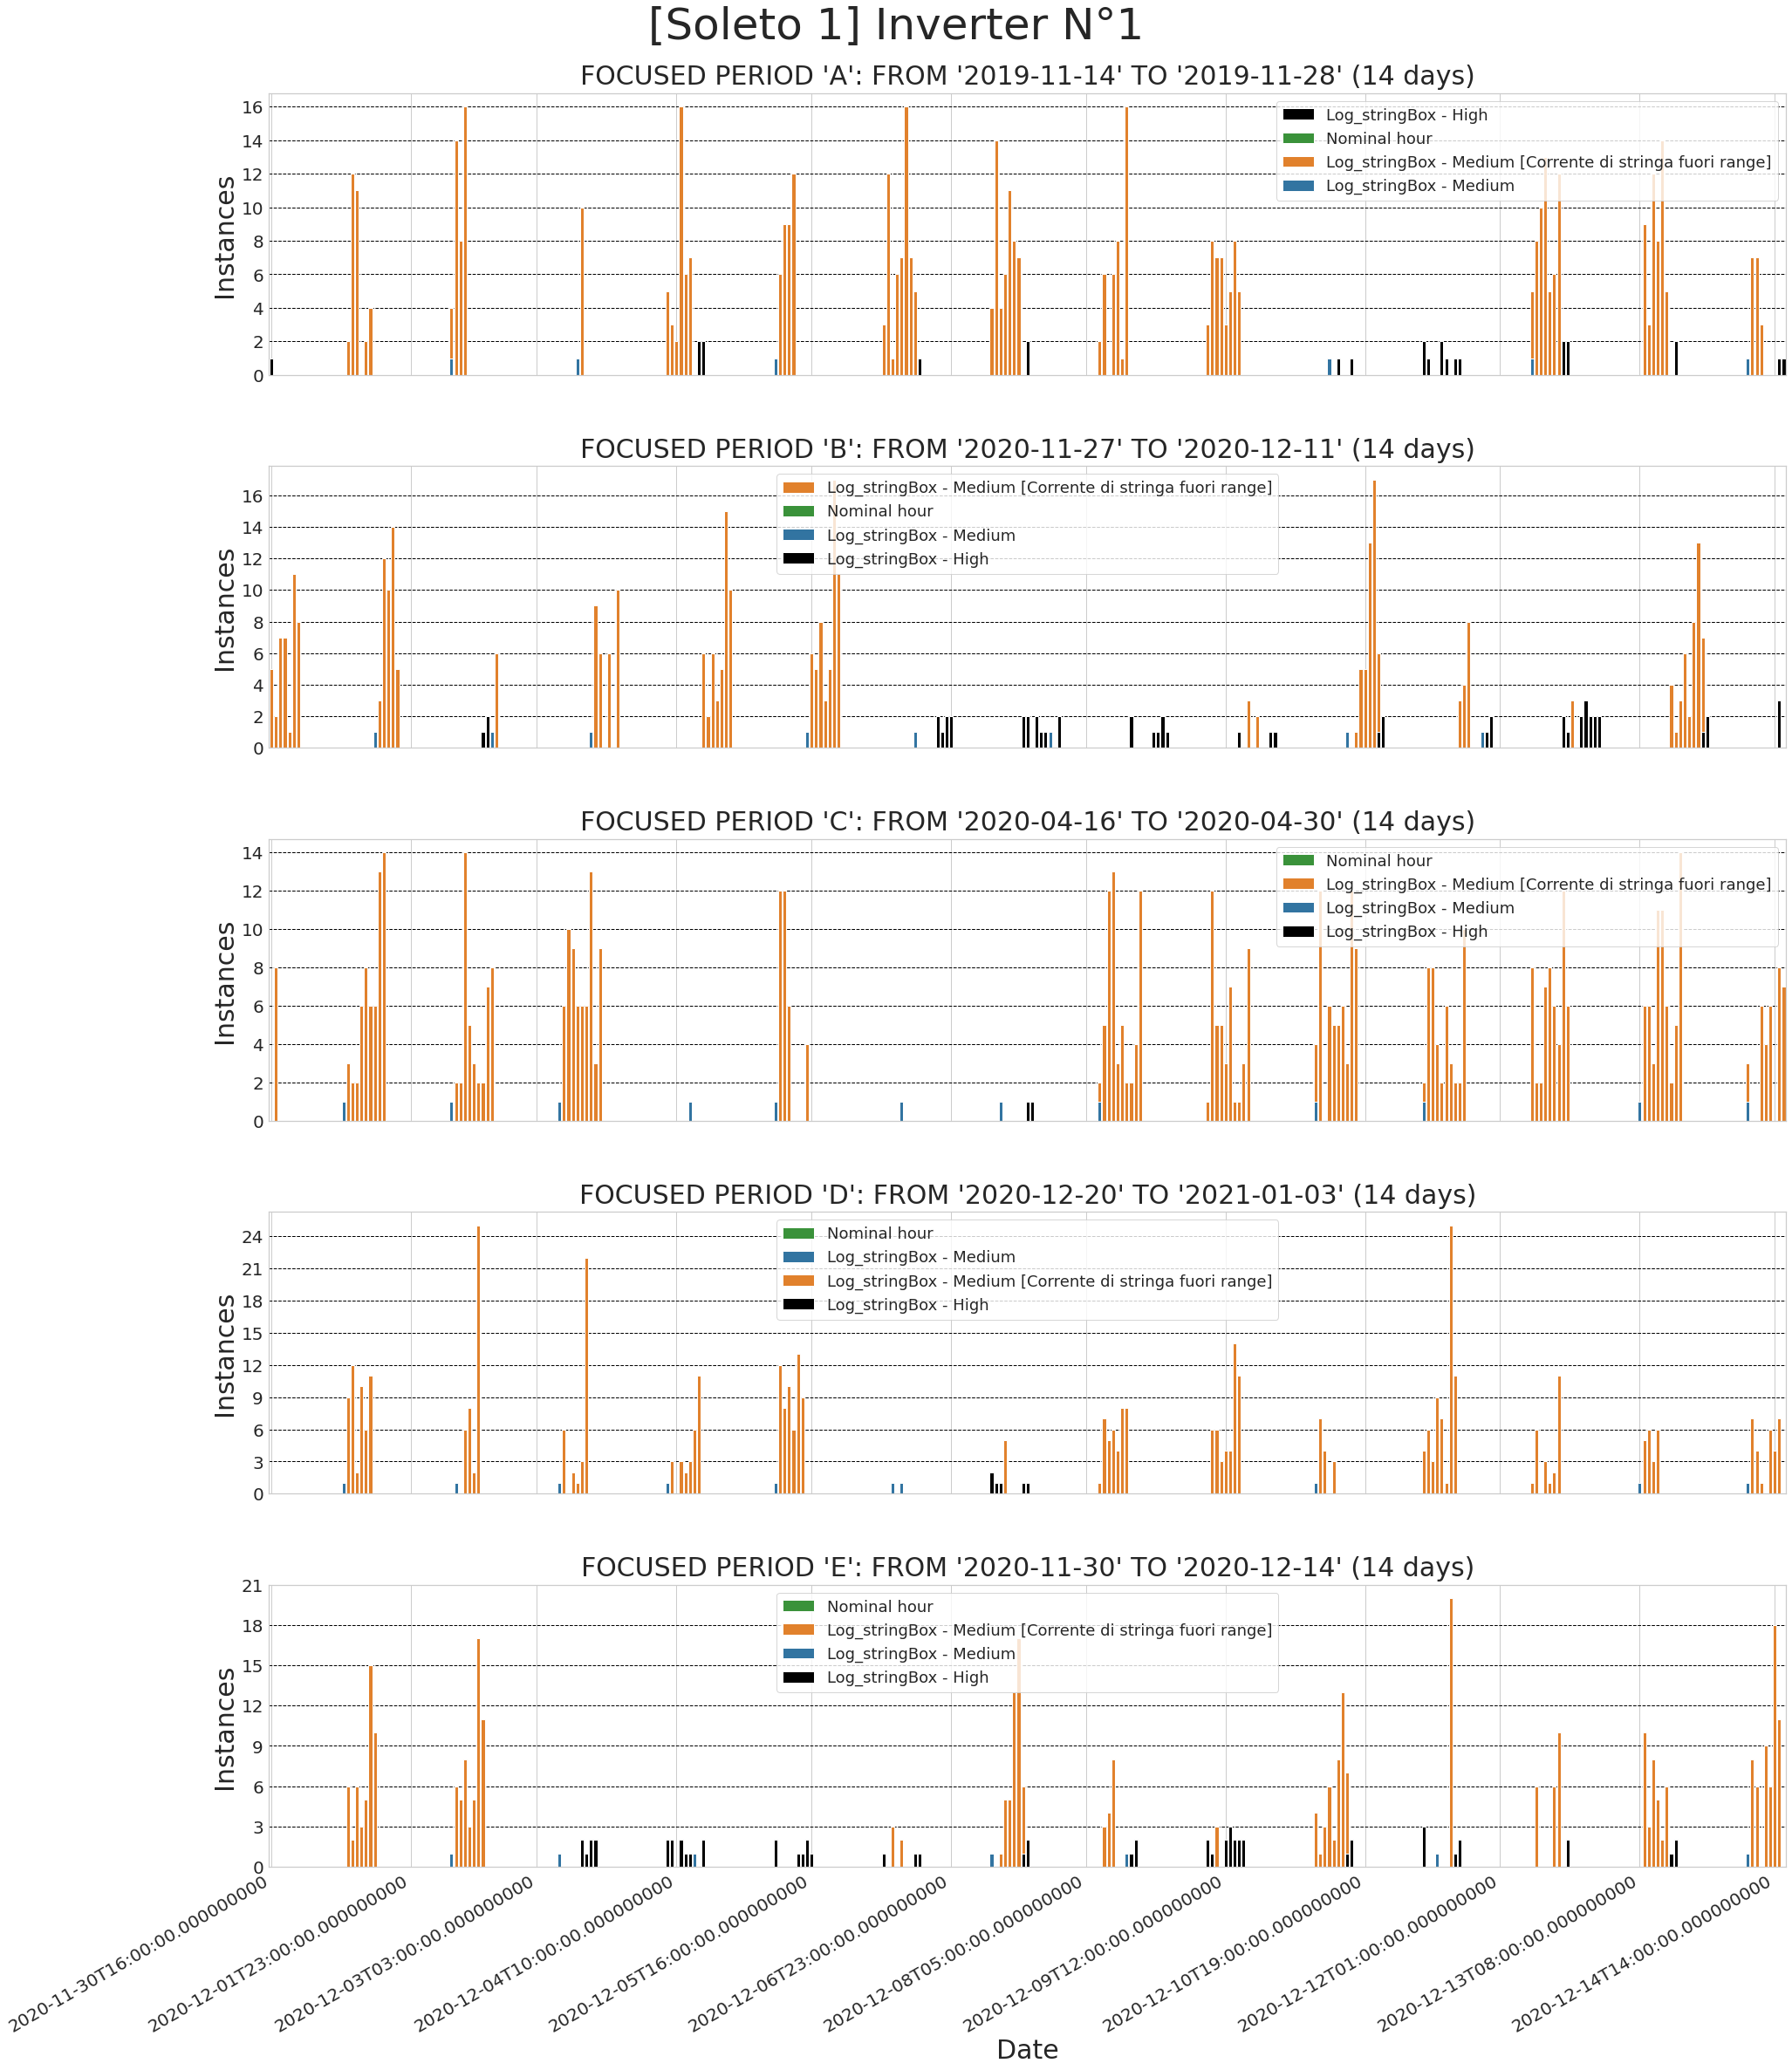


------------------------------------------------------- CORRELATIONS -------------------------------------------------------

------------------------------ CORRELATION BETWEEN ALARMS ([High alarms] tolernace = 0 hours) ------------------------------
SELECTED ALARMS (188): Log_stringBox - High
188


Int64Index([  114,   211,   215,   216,   389,   391,   408,   410,   413,
              418,
            ...
            21091, 21092, 21448, 22055, 22136, 22176, 22200, 26012, 26017,
            26031],
           dtype='int64', length=188)

SELECTED ALARMS (493): Log_stringBox - Medium
493


Int64Index([  190,  2592,  7411,  7674,  7747,  7892,  7915,  8010,  8035,
             8179,
            ...
            27047, 27137, 27161, 27242, 27258, 27290, 27307, 27331, 27332,
            27353],
           dtype='int64', length=493)

SELECTED ALARMS (5659): Log_stringBox - Medium [Corrente di stringa fuori range]
5659


Int64Index([    0,     1,     2,     3,     4,    18,    19,    20,    21,
               22,
            ...
            27378, 27380, 27382, 27384, 27385, 27386, 27402, 27405, 27406,
            27409],
           dtype='int64', length=5659)

alarmHigh_matrix ((188,))


array([1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1,
       1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1,
       2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 2, 1, 2, 2, 1, 2, 3, 2, 2, 2, 1, 2, 3, 1, 2, 2, 1, 2, 2,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1])

alarmMedium_matrix ((493,))


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

alarmHFMedium_matrix ((5659,))


array([2, 4, 1, ..., 1, 4, 9])


A) CORRELATION (High alarms, Medium Alarms):  -0.0104
B) CORRELATION (High alarms, High freq. medium alarms (i.e., 'corrente di stringa fuori range')):  -0.0301
C) CORRELATION (Medium alarms, High freq. medium alarms (i.e., 'corrente di stringa fuori range')):  -0.0529
------------------------------------------------------------ INV2 ------------------------------------------------------------

----------------------------------- ALARMS OF THE STRING BOXES CONNECTED TO THE INVERTER -----------------------------------


,Inverter,Componente Guasto,Causa Guasto,Inizio,Fine,Tipo,Hourly timestamp
5,2,CSP2.6 V180556 s9: [3] Corrente di stringa fuo...,Allarme string-box,2018-08-08 14:13:00,2018-08-08 14:21:00,Log_stringBox - Medium,2018-08-08 14:00:00
6,2,CSP2.6 V180556 s9: [3] Corrente di stringa fuo...,Allarme string-box,2018-08-08 14:33:00,2018-08-08 15:26:00,Log_stringBox - Medium,2018-08-08 15:00:00
8,2,CSP2.6 V180556 s4: [3] Corrente di stringa fuo...,Allarme string-box,2018-08-08 14:49:00,2018-08-08 15:26:00,Log_stringBox - Medium,2018-08-08 15:00:00
12,2,CSP2.6 V180556 s6: [3] Corrente di stringa fuo...,Allarme string-box,2018-08-08 15:01:00,2018-08-08 15:14:00,Log_stringBox - Medium,2018-08-08 15:00:00
13,2,CSP2.6 V180556 s5: [3] Corrente di stringa fuo...,Allarme string-box,2018-08-08 15:01:00,2018-08-08 15:14:00,Log_stringBox - Medium,2018-08-08 15:00:00
...,...,...,...,...,...,...,...
1101,2,CSP2.6 V180556 s1: [3] Corrente di stringa fuo...,Allarme string-box,2018-09-15 14:04:00,2018-09-15 14:16:00,Log_stringBox - Medium,2018-09-15 14:00:00
1103,2,CSP2.6 V180556 s9: [3] Corrente di stringa fuo...,Allarme string-box,2018-09-15 14:36:00,2018-09-15 14:47:00,Log_stringBox - Medium,2018-09-15 14:00:00
1106,2,CSP2.6 V180556 s9: [3] Corrente di stringa fuo...,Allarme string-box,2018-09-15 15:18:00,2018-09-15 17:15:00,Log_stringBox - Medium,2018-09-15 17:00:00
1108,2,CSP2.6 V180556 s1: [3] Corrente di stringa fuo...,Allarme string-box,2018-09-15 15:29:00,2018-09-15 17:15:00,Log_stringBox - Medium,2018-09-15 17:00:00



-------------------- [INV2] OVERVIEW --------------------
COVERED PERIOD: FROM '2018-08-08' TO '2020-09-30' 
DAYS: 784 days
HOURS: 18816 hours

--> Filled 17734 hours (94.2 %) which hadn't alarm logs


,Instances
Tipo,
Log_stringBox - High,6
Log_stringBox - Medium,48
Log_stringBox - Medium [Corrente di stringa fuori range],1037
Nominal hour,17734



-------------------------------------------------- GRAPHICAL PANELS --------------------------------------------------


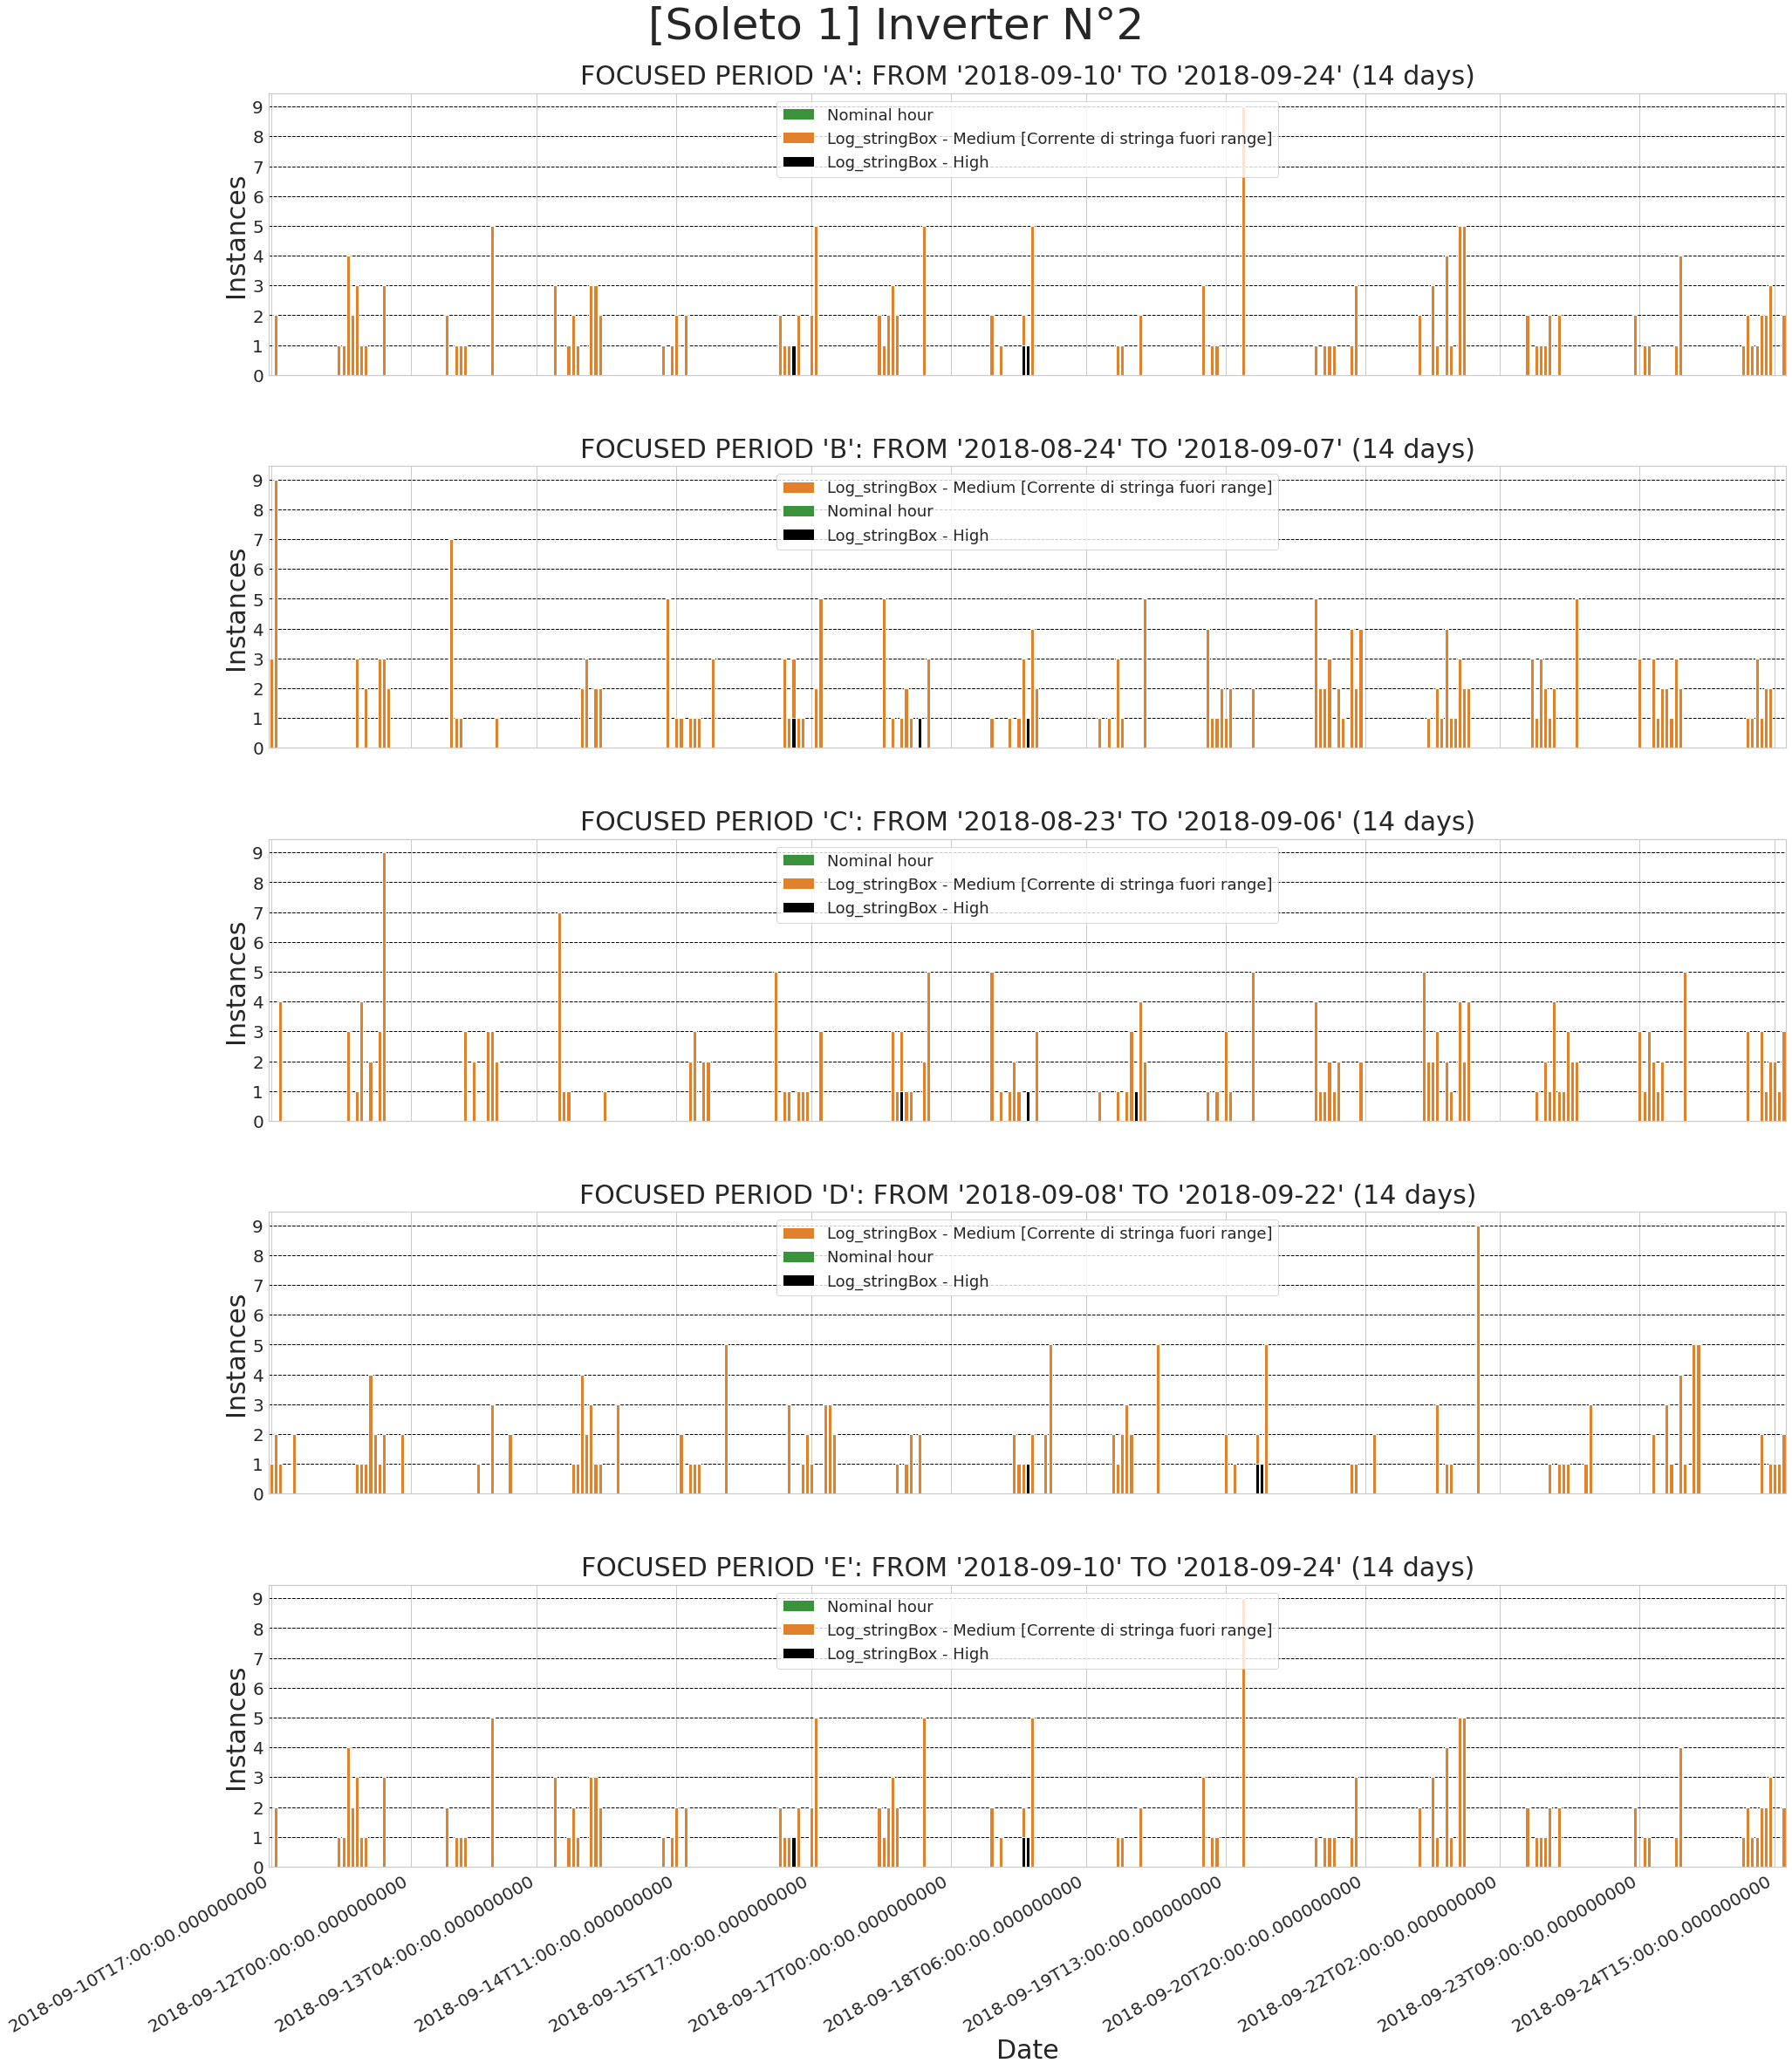


------------------------------------------------------- CORRELATIONS -------------------------------------------------------

------------------------------ CORRELATION BETWEEN ALARMS ([High alarms] tolernace = 0 hours) ------------------------------
SELECTED ALARMS (6): Log_stringBox - High
6


Int64Index([502, 531, 555, 912, 964, 966], dtype='int64')

SELECTED ALARMS (48): Log_stringBox - Medium
48


Int64Index([  189,  2523,  7342,  7678,  7822,  7846,  7941,  7966,  7991,
             8209,  8289,  8303,  8327,  8351,  8639,  8663,  8903,  8951,
             8975,  8999,  9071,  9095,  9720,  9767,  9863,  9887,  9911,
             9935,  9939,  9960,  9984, 10032, 10056, 10080, 10104, 10107,
            10128, 10152, 10176, 10205, 10224, 10248, 10272, 10296, 10321,
            14981, 14982, 18824],
           dtype='int64')

SELECTED ALARMS (1037): Log_stringBox - Medium [Corrente di stringa fuori range]
1037


Int64Index([    0,     1,     4,    18,    19,    21,    22,    24,    25,
               28,
            ...
            10302, 10303, 10304, 10305, 10322, 10323, 10324, 10326, 10327,
            10328],
           dtype='int64', length=1037)

alarmHigh_matrix ((6,))


array([1, 1, 1, 1, 1, 1])

alarmMedium_matrix ((48,))


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

alarmHFMedium_matrix ((1037,))


array([1, 6, 4, ..., 2, 4, 5])


A) CORRELATION (High alarms, Medium Alarms):  -0.0009
B) CORRELATION (High alarms, High freq. medium alarms (i.e., 'corrente di stringa fuori range')):  -0.0036
C) CORRELATION (Medium alarms, High freq. medium alarms (i.e., 'corrente di stringa fuori range')):  -0.0102
------------------------------------------------------------ INV3 ------------------------------------------------------------

----------------------------------- ALARMS OF THE STRING BOXES CONNECTED TO THE INVERTER -----------------------------------


,Inverter,Componente Guasto,Causa Guasto,Inizio,Fine,Tipo,Hourly timestamp
3,3,CSP3.6 V130086: String-box con produzione anomala,String-box con produzione anomala,2018-08-08 11:51:00,2018-10-18 14:50:00,Log_stringBox - Medium,2018-10-18 14:00:00
192,3,CSP3.6 V130086: Ritardo comunicazione dispositivo,Ritardo comunicazione dispositivo,2018-08-14 15:50:00,2018-08-16 11:29:00,Log_stringBox - Medium,2018-08-16 11:00:00
1876,3,CSP3.6 V130086 s5: [3] Corrente di stringa fuo...,Allarme string-box,2018-10-18 09:52:00,2018-10-18 10:04:00,Log_stringBox - Medium,2018-10-18 10:00:00
1889,3,CSP3.6 V130086 s5: [3] Corrente di stringa fuo...,Allarme string-box,2018-10-18 15:59:00,2018-10-18 16:26:00,Log_stringBox - Medium,2018-10-18 16:00:00
1902,3,CSP3.6 V130086 s5: [3] Corrente di stringa fuo...,Allarme string-box,2018-10-19 09:53:00,2018-10-19 10:05:00,Log_stringBox - Medium,2018-10-19 10:00:00
...,...,...,...,...,...,...,...
2448,3,CSP3.6 V130086 s5: [3] Corrente di stringa fuo...,Allarme string-box,2019-05-21 08:39:00,2019-05-21 09:32:00,Log_stringBox - Medium,2019-05-21 09:00:00
2449,3,CSP3.6 V130086 s5: [3] Corrente di stringa fuo...,Allarme string-box,2019-05-21 09:52:00,2019-05-21 10:00:00,Log_stringBox - Medium,2019-05-21 10:00:00
2450,3,CSP3.6 V130086 s5: [3] Corrente di stringa fuo...,Allarme string-box,2019-05-21 11:00:00,2019-05-21 11:06:00,Log_stringBox - Medium,2019-05-21 11:00:00
2451,3,CSP3.6 V130086 s5: [3] Corrente di stringa fuo...,Allarme string-box,2019-05-21 11:17:00,2019-05-21 11:30:00,Log_stringBox - Medium,2019-05-21 11:00:00



-------------------- [INV3] OVERVIEW --------------------
COVERED PERIOD: FROM '2018-08-16' TO '2021-09-16' 
DAYS: 1127 days
HOURS: 27048 hours

--> Filled 22789 hours (89.17 %) which hadn't alarm logs


,Instances
Tipo,
Log_stringBox - Medium,276
Log_stringBox - Medium [Corrente di stringa fuori range],2493
Nominal hour,22789



-------------------------------------------------- GRAPHICAL PANELS --------------------------------------------------


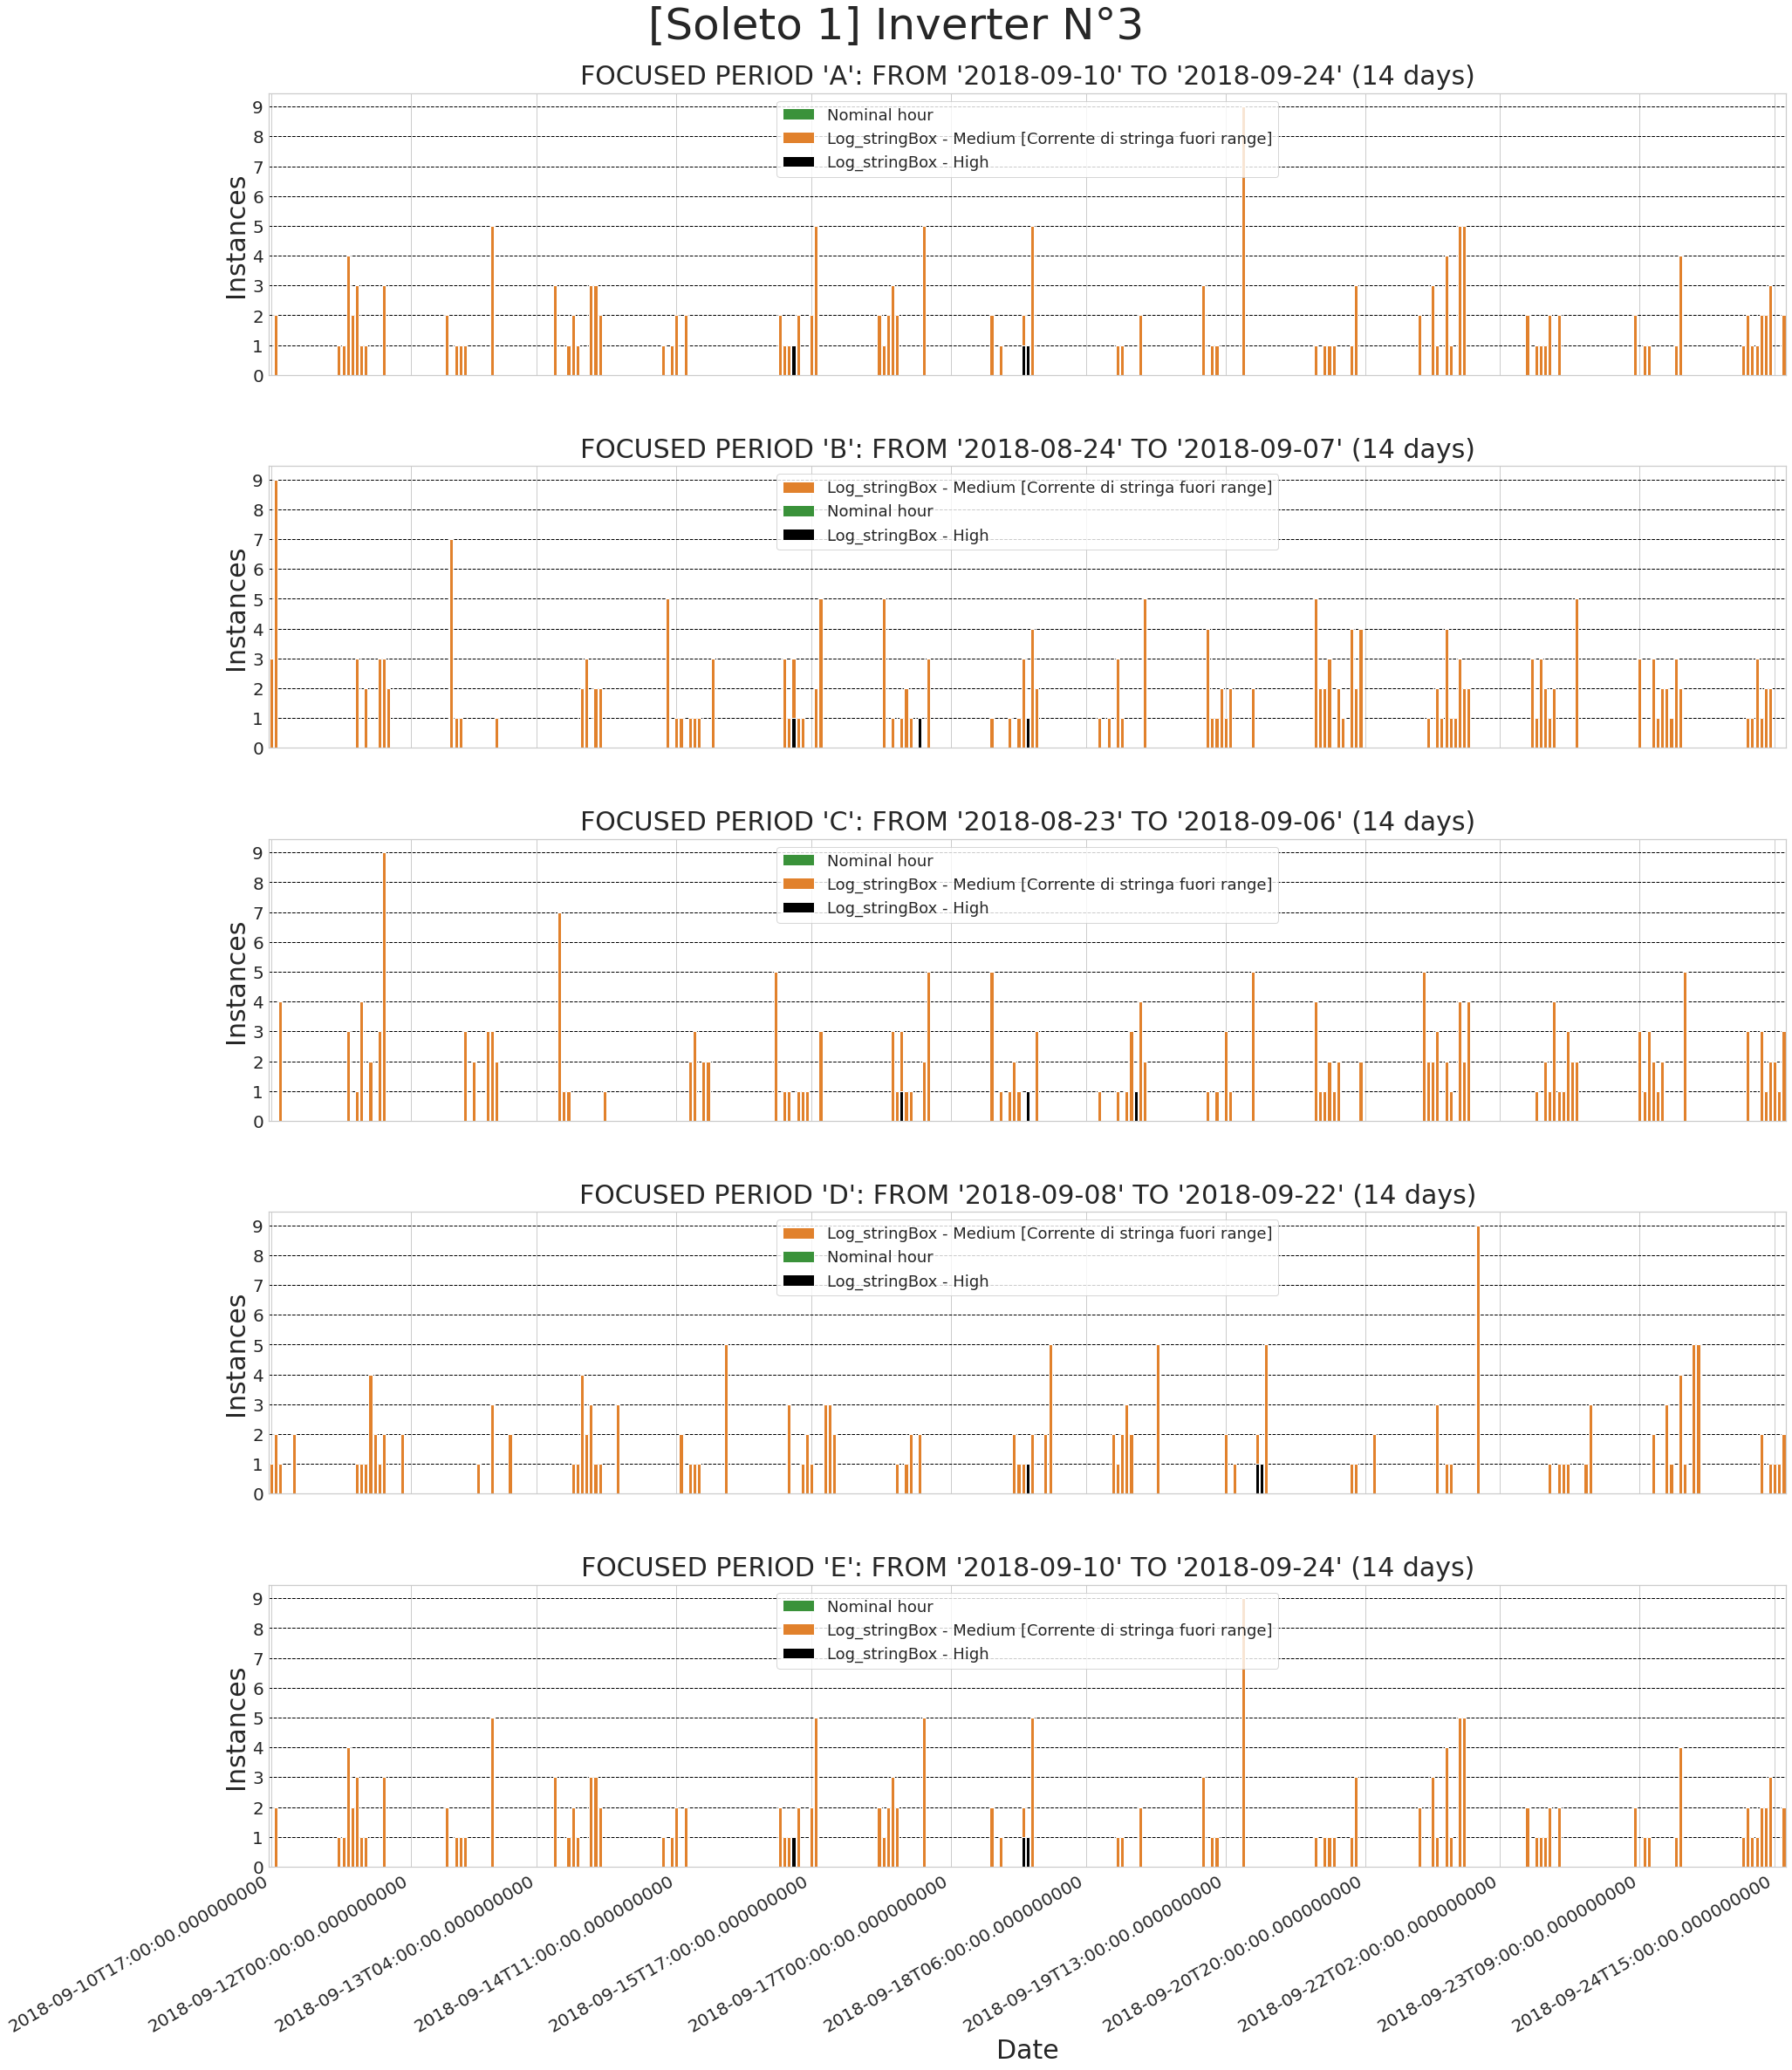


------------------------------------------------------- CORRELATIONS -------------------------------------------------------

------------------------------ CORRELATION BETWEEN ALARMS ([High alarms] tolernace = 0 hours) ------------------------------
SELECTED ALARMS (0): Log_stringBox - High
0


Int64Index([], dtype='int64')

SELECTED ALARMS (276): Log_stringBox - Medium
276


Int64Index([    0,     2,   818,  5637,  6236,  6260,  6285,  6597,  8014,
             9261,
            ...
            24854, 25047, 25050, 25094, 25286, 25367, 25383, 25415, 25455,
            25478],
           dtype='int64', length=276)

SELECTED ALARMS (2493): Log_stringBox - Medium [Corrente di stringa fuori range]
2493


Int64Index([    1,     4,    22,    28,    45,    52,    69,  1966,  1970,
             1971,
            ...
            25509, 25510, 25529, 25531, 25533, 25553, 25554, 25555, 25556,
            25557],
           dtype='int64', length=2493)

alarmHigh_matrix ((0,))


array([], dtype=int64)

alarmMedium_matrix ((276,))


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

alarmHFMedium_matrix ((2493,))


array([1, 1, 1, ..., 2, 2, 2])


A) CORRELATION (High alarms, Medium Alarms):  nan
B) CORRELATION (High alarms, High freq. medium alarms (i.e., 'corrente di stringa fuori range')):  nan
C) CORRELATION (Medium alarms, High freq. medium alarms (i.e., 'corrente di stringa fuori range')):  -0.026
------------------------------------------------------------ INV4 ------------------------------------------------------------

----------------------------------- ALARMS OF THE STRING BOXES CONNECTED TO THE INVERTER -----------------------------------


/home/vieri/anaconda3/envs/sample/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,Inverter,Componente Guasto,Causa Guasto,Inizio,Fine,Tipo,Hourly timestamp
38,4,CSP4.6 V180543 s1: [5] Allarme fusibile su pol...,Allarme string-box,2018-08-09 10:43:00,2018-08-09 11:58:00,Log_stringBox - High,2018-08-09 11:00:00
72,4,CSP4.6 V180543 s1: [5] Allarme fusibile su pol...,Allarme string-box,2018-08-10 08:12:00,2018-08-10 09:17:00,Log_stringBox - High,2018-08-10 09:00:00
181,4,CSP4.6 V180543 s1: [5] Allarme fusibile su pol...,Allarme string-box,2018-08-14 10:03:00,2018-08-14 10:26:00,Log_stringBox - High,2018-08-14 10:00:00
182,4,CSP4.6 V180543 s1: [5] Allarme fusibile su pol...,Allarme string-box,2018-08-14 10:35:00,2018-08-14 10:46:00,Log_stringBox - High,2018-08-14 10:00:00
191,4,CSP4.6 V180543: Ritardo comunicazione dispositivo,Ritardo comunicazione dispositivo,2018-08-14 15:50:00,2018-08-16 11:29:00,Log_stringBox - Medium,2018-08-16 11:00:00
...,...,...,...,...,...,...,...
14030,4,CSP4.6 V180543 s5: [3] Corrente di stringa fuo...,Allarme string-box,2020-01-01 14:18:00,2020-01-01 14:25:00,Log_stringBox - Medium,2020-01-01 14:00:00
14031,4,CSP4.6 V180543 s11: [3] Corrente di stringa fu...,Allarme string-box,2020-01-01 14:18:00,2020-01-01 14:25:00,Log_stringBox - Medium,2020-01-01 14:00:00
14032,4,CSP4.6 V180543 s2: [3] Corrente di stringa fuo...,Allarme string-box,2020-01-01 14:18:00,2020-01-01 14:25:00,Log_stringBox - Medium,2020-01-01 14:00:00
14033,4,CSP4.6 V180543 s9: [3] Corrente di stringa fuo...,Allarme string-box,2020-01-01 14:18:00,2020-01-01 14:25:00,Log_stringBox - Medium,2020-01-01 14:00:00



-------------------- [INV4] OVERVIEW --------------------
COVERED PERIOD: FROM '2018-08-09' TO '2021-09-17' 
DAYS: 1134 days
HOURS: 27216 hours

--> Filled 26714 hours (98.05 %) which hadn't alarm logs


,Instances
Tipo,
Log_stringBox - High,51
Log_stringBox - Medium,293
Log_stringBox - Medium [Corrente di stringa fuori range],188
Nominal hour,26714



-------------------------------------------------- GRAPHICAL PANELS --------------------------------------------------


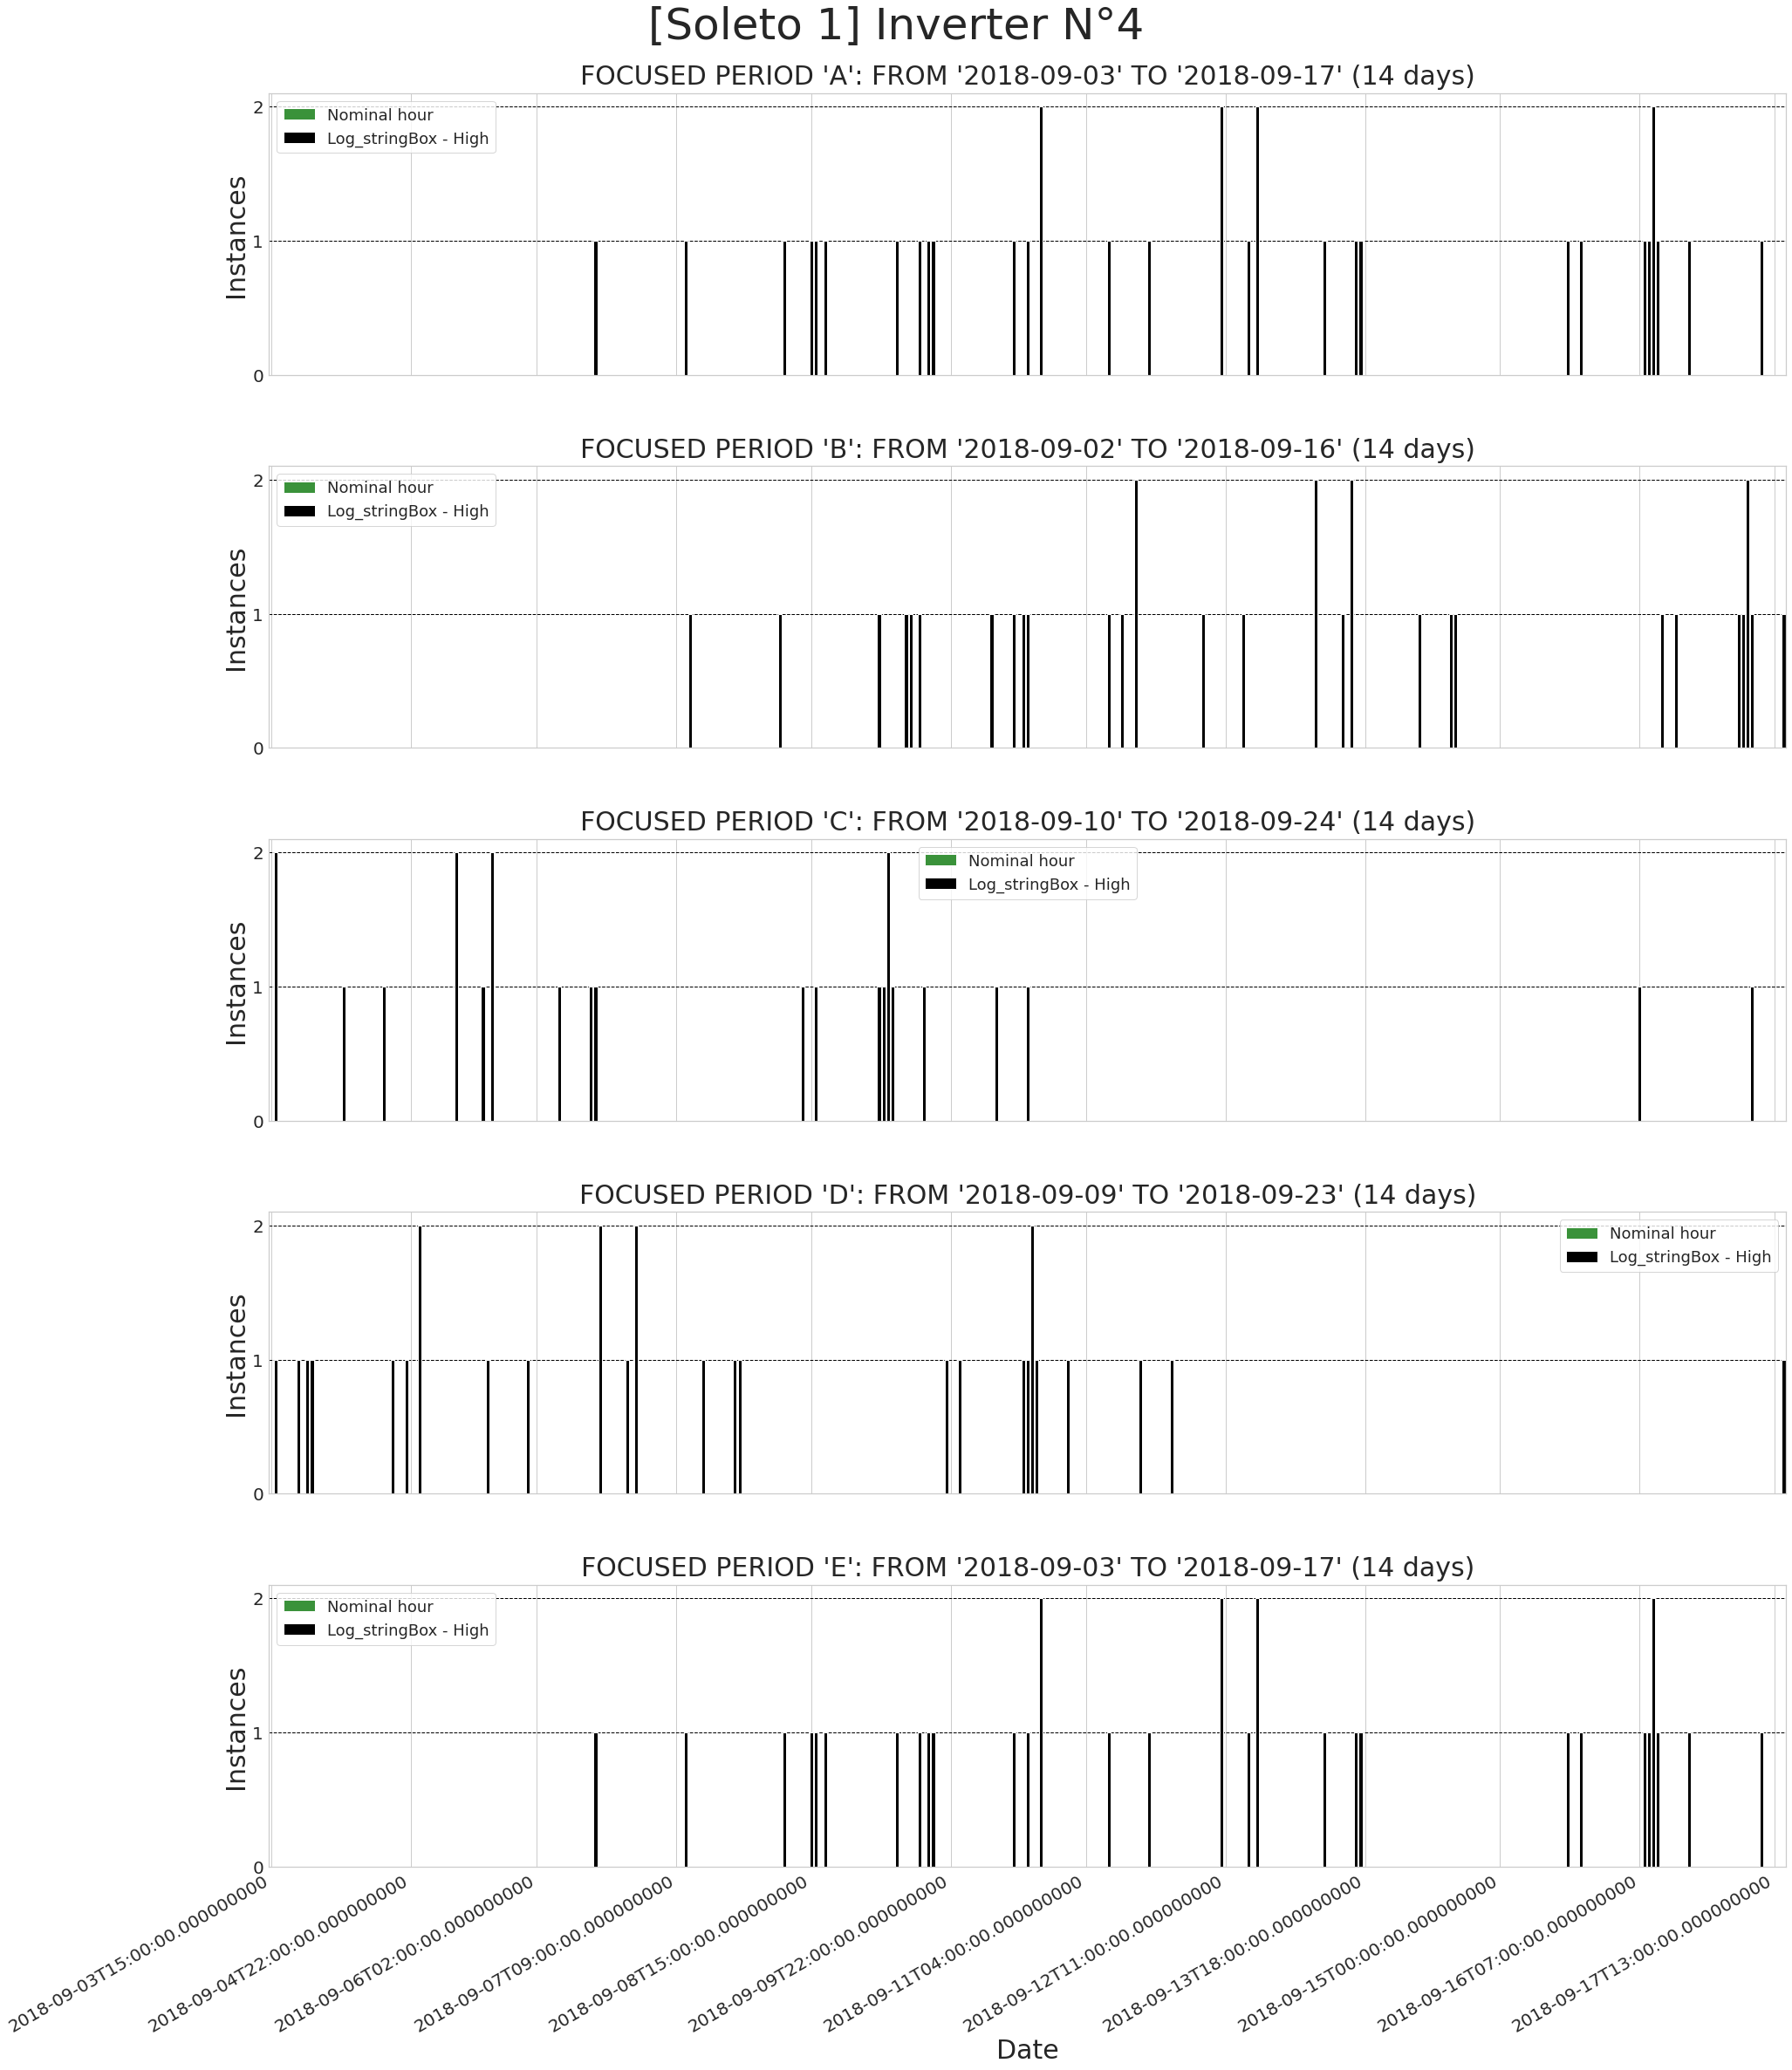


------------------------------------------------------- CORRELATIONS -------------------------------------------------------

------------------------------ CORRELATION BETWEEN ALARMS ([High alarms] tolernace = 0 hours) ------------------------------
SELECTED ALARMS (51): Log_stringBox - High
51


Int64Index([   0,   22,  119,  170,  189,  198,  199,  237,  238,  383,  384,
             390,  435,  439,  463,  486,  487,  533,  676,  696,  718,  724,
             725,  727,  743,  748,  750,  751,  769,  772,  775,  790,  799,
             815,  821,  823,  838,  845,  846,  892,  895,  909,  910,  911,
             912,  919,  935,  942, 1078, 1103, 1127],
           dtype='int64')

SELECTED ALARMS (293): Log_stringBox - Medium
293


Int64Index([  168,  1828,  2499,  7318,  7395,  7917,  7941,  7966,  9694,
            10080,
            ...
            26524, 26717, 26720, 26956, 27037, 27052, 27085, 27125, 27127,
            27148],
           dtype='int64', length=293)

SELECTED ALARMS (188): Log_stringBox - Medium [Corrente di stringa fuori range]
188


Int64Index([ 1662, 10948, 10996, 11236, 11283, 11308, 11379, 11403, 11475,
            11476,
            ...
            23072, 23673, 24249, 25785, 27173, 27204, 27225, 27228, 27244,
            27245],
           dtype='int64', length=188)

alarmHigh_matrix ((51,))


array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 2])

alarmMedium_matrix ((293,))


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

alarmHFMedium_matrix ((188,))


array([ 6,  4,  4, 12,  9, 12, 10,  1, 14,  6,  1,  8,  6,  1, 14,  6,  1,
       11,  1,  2,  1,  8,  2,  2, 15,  6,  2,  2, 20, 20,  6, 12,  2,  7,
        6,  1,  1,  1,  7,  6,  1, 24, 12,  2, 11,  2, 16,  6,  1, 14,  6,
        2, 14,  6,  1,  9,  6,  7,  1,  3, 12,  1, 17,  1,  1,  5, 12,  1,
        7, 12,  1,  8, 12,  1,  4, 12,  8, 12,  8, 12,  4,  2,  8,  9, 13,
        1,  2,  9,  5,  3,  2,  5,  6,  1,  3,  2,  9,  8,  9,  3,  7,  2,
        3,  4,  4,  5,  8,  5, 12,  4, 12,  4, 12, 13,  8,  6,  2,  8,  6,
        1, 12,  6,  6,  1, 17,  6, 15,  1, 10,  2,  1,  9, 12,  2, 20,  2,
       15,  4,  9,  1, 12, 16,  2, 13,  2,  7,  6,  1,  9,  2, 11,  2, 12,
        6,  2,  1,  2,  1,  2, 12, 12,  2, 11,  2, 12,  7, 12,  1,  4,  1,
        1, 12,  1, 12,  1,  7,  1, 10,  1,  5,  7, 12,  1,  1,  2,  1,  1,
        1])


A) CORRELATION (High alarms, Medium Alarms):  -0.0043
B) CORRELATION (High alarms, High freq. medium alarms (i.e., 'corrente di stringa fuori range')):  -0.0027
C) CORRELATION (Medium alarms, High freq. medium alarms (i.e., 'corrente di stringa fuori range')):  -0.0068


In [112]:
for inv_name in inv_names: 
    print("-" * 60, inv_name, "-" * 60)
    
    # Filter failire events by inverter number 
    inv_number = int(inv_name[-1])
    inv_alarms = fault_df[fault_df['Inverter'] == inv_number]
    
    print("\n"+ "-" * 35, "ALARMS OF THE STRING BOXES CONNECTED TO THE INVERTER", "-" * 35)
    display(inv_alarms.iloc[:500])
    
    # Create a sub-category
    message_name = 'Corrente di stringa fuori range'
    hf_type_name = f'Log_stringBox - Medium [{message_name}]'
    cond = inv_alarms['Componente Guasto'].str.contains(message_name)
    inv_alarms.loc[cond, 'Tipo'] = hf_type_name
    
    if drop_high_freq_category:
        inv_alarms = inv_alarms[inv_alarms['Tipo'] != type_name]

    if filling_empty_hours:
        type_name = "Nominal hour"
        timestamps_ranges = pd.date_range(start = inv_alarms['Hourly timestamp'].iloc[0], 
                                          end = inv_alarms['Hourly timestamp'].iloc[-1], freq = "1H")
        
        missing_hours = [ts for ts in timestamps_ranges if ts not in inv_alarms['Hourly timestamp'].values]
        
        to_add = pd.DataFrame([pd.Series({'Inverter': inv_number, 'Componente Guasto': "-", 
                             'Causa Guasto': "-", "Inizio" : "-", "Fine": "-", 
                             "Tipo": type_name, 'Hourly timestamp': hour}) 
                            for hour in missing_hours])
        
        inv_alarms = pd.concat([inv_alarms, to_add], ignore_index = True)
        inv_alarms = inv_alarms.sort_values (by = 'Hourly timestamp')
    
    # Group alarms
    grouped_alarms = inv_alarms.groupby(by = ['Hourly timestamp', 'Tipo'], as_index = False).count()
    grouped_alarms = grouped_alarms[['Hourly timestamp', 'Tipo', 'Inverter']].rename(columns = {'Inverter': 'Instances'})
    grouped_alarms.sort_values(by = ['Hourly timestamp'], inplace = True)
    print("\n"+ "-" * 20, f"[{inv_name}] OVERVIEW", "-" * 20)
    print(f"COVERED PERIOD: FROM '{grouped_alarms.iloc[0, 0].strftime('%Y-%m-%d')}' "\
          f"TO '{grouped_alarms.iloc[-1, 0].strftime('%Y-%m-%d')}' ")
    print("DAYS:", (grouped_alarms.iloc[-1, 0] - grouped_alarms.iloc[0, 0]).days, "days")
    print("HOURS:", (grouped_alarms.iloc[-1, 0] - grouped_alarms.iloc[0, 0]).days * 24, "hours")
    if filling_empty_hours:
        print(f"\n--> Filled {len(missing_hours)} hours ({np.round((len(missing_hours)/len(grouped_alarms))*100, 2)} %) "\
              "which hadn't alarm logs")
        
    display(grouped_alarms.groupby(by = 'Tipo').count()['Instances'].to_frame().sort_index(ascending = True))
    
    # Select a small subset
    alarm_high_df = grouped_alarms.loc[grouped_alarms['Tipo'] == 'Log_stringBox - High', 'Hourly timestamp']

    days_to_include = 7
    num_periods = 5
    use_main_focus = True
    if use_main_focus and len(alarm_high_df) > 0:
        periods = []
        delta_days = pd.Timedelta(days_to_include, unit = 'days')
        
        for idk in range(num_periods):
            
            # Isolate the periods
            starting_date = alarm_high_df.sample(1, random_state = idk * 10).iloc[0]
            main_focus = (starting_date - delta_days, starting_date + delta_days)
            
            # Isolate the observations
            period_cond = grouped_alarms['Hourly timestamp'].between(main_focus[0], main_focus[1])
            selected_period = grouped_alarms[period_cond].reset_index(drop = True)
            periods.append(selected_period)

    print("\n"+ "-" * 50, f"GRAPHICAL PANELS", "-" * 50)
    
    fig, axes = plt.subplots(nrows = num_periods, figsize=(30, 7 * num_periods), sharex=False, sharey=False)
    fig.suptitle(f'[{system_name}] Inverter N°{inv_number}', fontsize = 50, y = 0.96) # y = 1.15
    colors = {"Nominal hour": "tab:green", "Log_stringBox - High": "black", "Log_stringBox - Medium": "tab:blue", 
              "Log_stringBox - Medium [Corrente di stringa fuori range]":"tab:orange"}
    for idk, period_df in enumerate(periods):
        starting_date = period_df.iloc[0, 0]
        ending_date = period_df.iloc[-1, 0]
        
        period_string = f"FOCUSED PERIOD '{ascii_uppercase[idk]}': FROM '{starting_date.strftime('%Y-%m-%d')}' "\
                        f"TO '{ending_date.strftime('%Y-%m-%d')}' ({(ending_date - starting_date).days} days)"
        # PANEL: Figure
        axes[idk].set_title(period_string, fontsize = 30, pad = 10)
        
        # PANEL: Histogram
        if empty_hours_to_zero:
            nominal_cond = period_df['Tipo'] == type_name
            period_df.loc[nominal_cond, 'Instances'] = 0
    
        sns.barplot(x = period_df['Hourly timestamp'], y = period_df['Instances'], hue = period_df['Tipo'],
                    ax = axes[idk], dodge = False, palette = colors)

        # PANEL: Graphical parameter
        axes[idk].set_xlabel('Date', fontsize = 30)
        axes[idk].set_ylabel('Instances', fontsize = 30)
        #axes.set_ylim(bottom = 1)

        axes[idk].yaxis.set_major_locator(MaxNLocator(integer=True))
        axes[idk].xaxis.set_major_locator(AutoDateLocator())
        #axes.xaxis.set_minor_locator(DayLocator(interval = 1))
        
        axes[idk].tick_params(direction='inout', grid_linewidth = 1, labelsize = 20)
        axes[idk].tick_params(axis = 'y', direction='inout', grid_linewidth = 1, grid_linestyle = '--', grid_color = "black")
        #axes.tick_params(which = 'minor', direction='inout', grid_linewidth = 0.5, grid_linestyle = '--')
        
        axes[idk].legend(prop = {"size" : 18})
        axes[idk].grid(visible = True, which = 'both', axis = 'both')
        
        if verbose: 
            print(period_string)
            display(period_df)
    
    #plt.yticks(fontsize = 20)
    #plt.xticks(fontsize = 20)
    
    fig.autofmt_xdate()
    fig.tight_layout(pad = 5)
    
    #plt.legend(prop = {"size":20})
    plt.show()
    
    # Compute alarm matrices
    hourly_tolernace_values = [0] #, 3, 6, 12
    print("\n"+ "-" * 55, f"CORRELATIONS", "-" * 55)
    for hours in hourly_tolernace_values:
        
        # Compute the 
        #print("PRE")
        #display(grouped_alarms)
        alarm_df = df_with_previous_obs(grouped_alarms, hours_to_consider = hours)
        #print("POST ")
        #display(alarm_df)
        
        print("\n"+ "-" * 30, f"CORRELATION BETWEEN ALARMS ([High alarms] tolernace = {hours} hours)", "-" * 30)
        alarmHigh_matrix = generate_num_matrix(alarm_df, alarm_type = 'Log_stringBox - High')
        alarmMedium_matrix = generate_num_matrix(alarm_df, alarm_type = 'Log_stringBox - Medium')
        alarmHFMedium_matrix = generate_num_matrix(alarm_df, alarm_type = hf_type_name)
        
        print(f"alarmHigh_matrix ({np.nonzero(alarmHigh_matrix)[0].shape})")
        display(alarmHigh_matrix[np.nonzero(alarmHigh_matrix)])
        print(f"alarmMedium_matrix ({np.nonzero(alarmMedium_matrix)[0].shape})")
        display(alarmMedium_matrix[np.nonzero(alarmMedium_matrix)])
        print(f"alarmHFMedium_matrix ({np.nonzero(alarmHFMedium_matrix)[0].shape})")
        display(alarmHFMedium_matrix[np.nonzero(alarmHFMedium_matrix)])
        
        # Compute correlations
        high_Medium_corr, _ = stats.pearsonr(alarmHigh_matrix, alarmMedium_matrix)
        high_hf_Medium_corr, _ = stats.pearsonr(alarmHigh_matrix, alarmHFMedium_matrix)
        medium_hf_medium_corr, _ = stats.pearsonr(alarmMedium_matrix, alarmHFMedium_matrix)
        print("\nA) CORRELATION (High alarms, Medium Alarms): ", np.round(high_Medium_corr, 4))
        print("B) CORRELATION (High alarms, High freq. medium alarms "\
              f"(i.e., 'corrente di stringa fuori range')): ", np.round(high_hf_Medium_corr, 4))
        print("C) CORRELATION (Medium alarms, High freq. medium alarms "\
              f"(i.e., 'corrente di stringa fuori range')): ", np.round(medium_hf_medium_corr, 4))
        
    # Alternative approach


In [111]:
x = pd.Series(range(5)) #tmp['Instances']
display(x)
for win_dim in range(5):
    new_x = x.rolling(window = win_dim).sum()
    display(new_x)
    
# 

0    0
1    1
2    2
3    3
4    4
dtype: int64

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64

0    0.0
1    1.0
2    2.0
3    3.0
4    4.0
dtype: float64

0    NaN
1    1.0
2    3.0
3    5.0
4    7.0
dtype: float64

0    NaN
1    NaN
2    3.0
3    6.0
4    9.0
dtype: float64

0     NaN
1     NaN
2     NaN
3     6.0
4    10.0
dtype: float64